In [1]:
import numpy as np
import h5py
from copy import deepcopy
import os, zipfile, shutil,gzip
import pandas as pd
import glob
from scipy.stats import linregress
import os
from datetime import datetime
from datetime import timedelta
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import scipy
from numpy import polyfit, poly1d
from scipy import interpolate
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import time
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq
import math
import plotly
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import json
from scipy.interpolate import interp1d
from scipy.spatial.distance import euclidean
from scipy import interpolate

secret='TD.a-ZsKkoLFWpWQpFK.dejlvOF7NK0XBVM.LlD63gOWm7VaNIu.WzC3t3XtgjavrVM.PxZSkA5B3pBRC2T.baP4'
import nest_asyncio
nest_asyncio.apply()
from tardis_dev import datasets

if not sys.warnoptions:
    warnings.simplefilter("ignore")

D:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## binance对冲模拟

In [2]:
def read_dic(name):
    file = open(f'C:/Users/杜威/Desktop/tardis/Tom_data/params/{name}.txt', 'r')
    content = file.read()
    dictionary = eval(content)
    file.close()
    return dictionary
balance_map = read_dic('balance')
credit_map = read_dic('credit')

In [3]:
def profit_loss(raw):
    if raw['ch'] <= 0:
        return raw['ch'] * raw['asks[0].price']
    else:
        return raw['ch'] * raw['bids[0].price']

def profit_fp(raw):
    return raw['ch'] * raw['fp']
    
def profit_a(raw):
    if raw['ch'] <= 0:
        return raw['ch'] * raw['asks[0].price'] * (1 + 0.000155)
    else:
        return raw['ch'] * raw['bids[0].price'] * (1 - 0.000155)

def profit_b(raw):
    depth = abs(raw['ch'])
    if depth == 0:
        return 0
    if raw['ch'] <= 0:
        side = 'ask'
    else:
        side = 'bid'
    value = 0
    amount = 0
    for k in range(25):
        value += raw[f'{side}s[{k}].price'] * raw[f'{side}s[{k}].amount']
        amount += raw[f'{side}s[{k}].amount']
        while amount > depth:
            value = (value - raw[f'{side}s[{k}].price'] * raw[f'{side}s[{k}].amount'] + 
                    (depth - amount + raw[f'{side}s[{k}].amount']) * raw[f'{side}s[{k}].price']) / depth * raw['ch']
            return value - abs(value) * 0.000155
    value = (value + (depth - amount) * raw[f'{side}s[{k}].price']) / depth * raw['ch']
    return value - abs(value) * 0.000155

def pos_choose(pos_kk_now):
    global pos_bi_now
    global lim
    pos_bi_next = pos_kk_now    # pos_bi_next: binance将要跟随的头寸
    if abs(pos_kk_now) < lim :    
        pos_bi_next = pos_bi_now
    elif (  pos_kk_now > 0 ) and (  pos_kk_now < pos_bi_now ):
        pos_bi_next = pos_bi_now
    elif (  pos_kk_now < 0 ) and (  pos_kk_now > pos_bi_now ):
        pos_bi_next = pos_bi_now
    pos_bi_now = pos_bi_next
    return pos_bi_next

def cal_profit(df):
    df.loc[0,'pos'] = 0
    df['pos_'] = df['pos'].shift(-1).fillna(0)
    df['ch'] = df['pos_'] - df['pos']
    pa = df.apply(profit_a, axis =1).sum()
    pb = df.apply(profit_b, axis =1).sum()
    return round(pa,2),round(pb,2)

def all_profit(ex_ls, part_ls):
    global pos_bi_now 
    global lim
    for ex in ex_ls:
        for coin_part in part_ls:
            balance = balance_map[str(int(coin_part)-2)]
            credit = credit_map[str(int(coin_part)-2)]
            final = []
            for coin in os.listdir(f'C:/Users/杜威/Desktop/tardis/profit/pos_ch_takeprice/{ex}/{coin_part}'):
                coin = coin[:-4]
                coin1 = coin[:-4].replace('DOGE','XDG').lower()
                df = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/profit/pos_ch_takeprice/{ex}/{coin_part}/{coin}.csv')
                p1,p2 = cal_profit(df)
                p = df.apply(profit_loss, axis =1).sum()
                f = df.apply(profit_fp, axis =1).sum()
                pos_bi_now = 0
                lim = (balance[f'{ex}'][f'{coin1}'] + credit[f'{ex}'][f'{coin1}']) * 0.3
                df['pos'] = df['pos'].apply(pos_choose)
                p3,p4 = cal_profit(df)
                final.append([coin1,round(f,2),round(p,2),p1,p2,p3,p4])
            df = pd.DataFrame(final, columns = ['coin','fp_kk','No Fee', 'Fully hedged min price', 'Fully hedged change price', 
                                                'strategy min price', 'strategy change price'])
            bot = (['all'] + list(df.iloc[:,1:].sum(axis = 0)))
            final.append(bot)
            df = pd.DataFrame(final, columns = ['coin','fp_kk','No Fee', 'Fully hedged min price', 'Fully hedged change price', 
                                                'strategy min price', 'strategy change price'])
            df.to_csv(f'C:/Users/杜威/Desktop/tardis/profit/new x/ch/{ex}_{coin_part}.csv')
            
def delay_profit(ex_ls, part_ls):
    name_ls = ['0ms', '60ms', '500ms', '1s', '10s', '1min', '10min', '1h']
    global pos_bi_now 
    global lim
    for ex in ex_ls:
        for coin_part in part_ls:
            balance = balance_map[str(int(coin_part)-2)]
            credit = credit_map[str(int(coin_part)-2)]
            final = []
            for coin in os.listdir(f'C:/Users/杜威/Desktop/tardis/profit/pos_mult_takeprice/{ex}/{coin_part}'):
                value_ls = []
                coin = coin[:-4]
                coin1 = coin[:-4].replace('DOGE','XDG').lower()
                df = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/profit/pos_mult_takeprice/{ex}/{coin_part}/{coin}.csv').ffill()
                
                df.loc[0,'pos'] = 0
                df['pos_'] = df['pos'].shift(-1).fillna(0)
                df['ch'] = df['pos_'] - df['pos']
                df['asks[0].price'] = df[f'60ms_ask']
                df['bids[0].price'] = df[f'60ms_bid']
                p = df.apply(profit_loss, axis =1).sum()
                f = df.apply(profit_fp, axis =1).sum()
                value_ls = [coin1,round(f,2),round(p,2)]
                for diff in name_ls:
                    df['asks[0].price'] = df[f'{diff}_ask']
                    df['bids[0].price'] = df[f'{diff}_bid']
                    t = df.apply(profit_a, axis =1).sum()
                    value_ls.append(round(t,2))
                    
                pos_bi_now = 0
                lim = (balance[f'{ex}'][f'{coin1}'] + credit[f'{ex}'][f'{coin1}']) * 0.3
                df['pos'] = df['pos'].apply(pos_choose)
                df.loc[0,'pos'] = 0
                df['pos_'] = df['pos'].shift(-1).fillna(0)
                df['ch'] = df['pos_'] - df['pos']
                for diff in name_ls:
                    df['asks[0].price'] = df[f'{diff}_ask']
                    df['bids[0].price'] = df[f'{diff}_bid']
                    t = df.apply(profit_a, axis =1).sum()
                    value_ls.append(round(t,2))
                    
                final.append(value_ls)
                
            cols = ['coin','fp_kk','No Fee']
            for diff in name_ls:
                cols += [f'Fully_{diff}']
            for diff in name_ls:
                cols += [f'Strategy_{diff}']
            df = pd.DataFrame(final, columns = cols)
            bot = (['all'] + list(df.iloc[:,1:].sum(axis = 0)))
            final.append(bot)
            df = pd.DataFrame(final, columns = cols)
            df.to_csv(f'C:/Users/杜威/Desktop/tardis/profit/new x/mult/{ex}_{coin_part}.csv')

In [12]:
ex_ls = ['kraken_formal', 'kraken_test'][:1]
part_ls = ['9']
all_profit(ex_ls, part_ls)

In [20]:
delay_profit(ex_ls, part_ls)

# 观察阈值

In [66]:
def test_threshold(ex_ls, part_ls, file_name):
    balance_map = read_dic('balance')
    credit_map = read_dic('credit')
    global pos_bi_now 
    global lim
    path = f'C:/Users/杜威/Desktop/tardis/profit/new x/threshold/{file_name}'
    if not os.path.exists(path):
        os.mkdir(path)
    for coin in os.listdir(f'C:/Users/杜威/Desktop/tardis/profit/pos_ch_takeprice/kraken_formal/5'):
        pos_ls = np.arange(0,1.01,0.01)
        m_ls = [0] * len(pos_ls)
        ch_ls = [0] * len(pos_ls)
        coin = coin[:-4]
        coin1 = coin[:-4].replace('DOGE','XDG').lower()
        for ex in ex_ls:
            for coin_part in part_ls:
                balance = balance_map[str(int(coin_part)-2)]
                credit = credit_map[str(int(coin_part)-2)]
                df0 = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/profit/pos_ch_takeprice/{ex}/{coin_part}/{coin}.csv')
                for i in range(len(pos_ls)):
                    df = df0[:]
                    pos_bi_now = 0
                    lim = (balance[f'{ex}'][f'{coin1}'] + credit[f'{ex}'][f'{coin1}']) * pos_ls[i]
                    df['pos'] = df['pos'].apply(pos_choose)
                    p3,p4 = cal_profit(df)
                    m_ls[i] += p3
                    ch_ls[i] += p4
        plt.figure(figsize=(15, 8))
        plt.plot(pos_ls,m_ls,label = f'min price')
        plt.plot(pos_ls,ch_ls,label = f'change price')
        plt.plot(pos_ls,[ch_ls[0] for i in ch_ls],label = 'baseline')
        plt.title(f'{coin}')
        plt.xlabel('Hedging threshold')
        plt.ylabel('Dallor value')
        plt.legend()
        plt.savefig(f'C:/Users/杜威/Desktop/tardis/profit/new x/threshold/{file_name}/{coin}.jpg') 

## 策略研究

In [81]:
dt = pd.read_excel(r'D:\临时下载\predfcv.xlsx')
dt['time_D'] = dt['time'].astype('datetime64[m]')

In [82]:
def pos_choose_pred(pre):
    global pos_bi_now
    global lim
    if pre > lim:
        pos_bi_next = 1
    elif pre < -1 * lim:
        pos_bi_next = -1
    elif pre * pos_bi_now >= 0:
        pos_bi_next = pos_bi_now
    elif pre * pos_bi_now <= 0:
        pos_bi_next = 0
    pos_bi_now = pos_bi_next
    return pos_bi_next
lim = 0.0005
pos_bi_now = 0
dt['pos'] = dt['predict2'].apply(pos_choose)
dt = pp_cal(dt)[0]

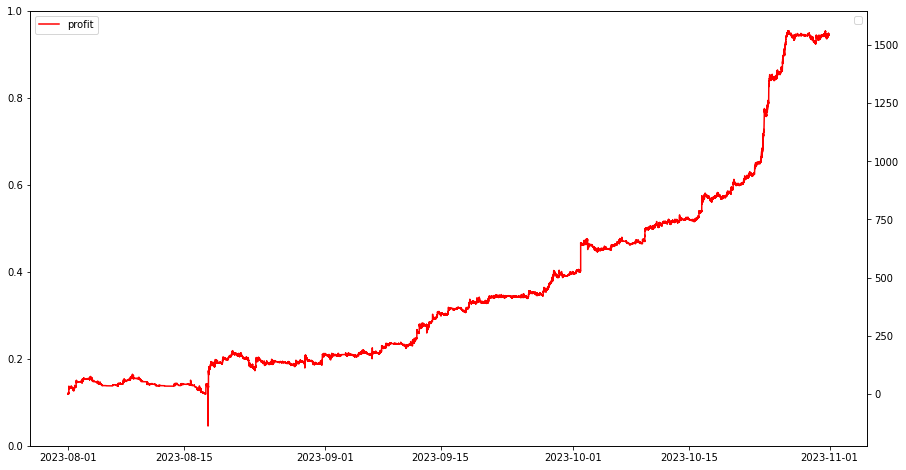

In [84]:
fig, ax1 = plt.subplots(figsize = (15, 8 ))
#ax1.plot(dt.time, dt.pos, label = 'pos')
plt.legend('uppper left')
ax2 = ax1.twinx()  
ax2.plot(dt.time, dt.profit, color = 'red', label = 'profit')
plt.legend()

In [61]:
#收益和kraken亏损比较

In [39]:
df = pd.read_csv(r'D:\临时下载\eth.csv')
df['time'] = df['time'].astype('datetime64[m]')
df = df[df['time'] < '2023-11-06']
df = df.groupby('time', as_index = False).sum()

In [40]:
dt['return'] = dt['profit'].diff()
df0 = pd.merge(df, dt, on = 'time', how = 'right')[['time', 'fp_diff', 'return']].dropna()
df0['profit'] = df0['return'].cumsum()
df0['fp'] = -1 * df0.fp_diff.cumsum()

corr:  0.7525555618535421


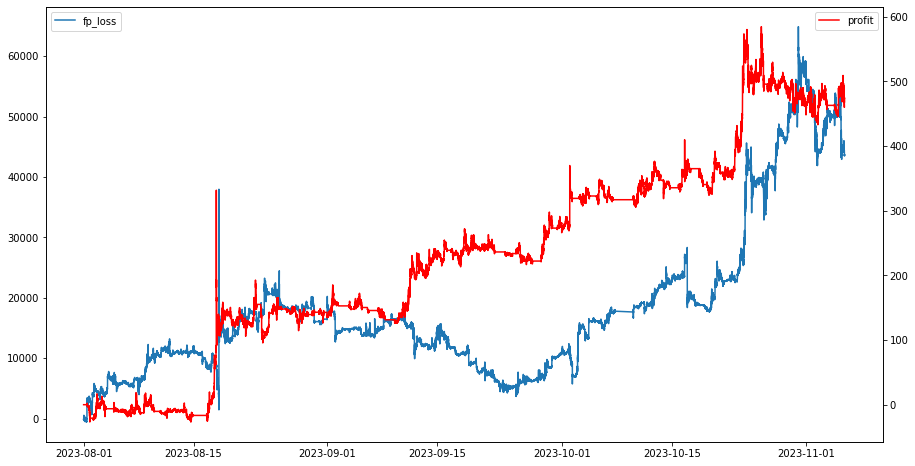

In [98]:
fig, ax1 = plt.subplots(figsize = (15, 8 ))
ax1.plot(df0.time, df0['fp'], label = 'fp_loss')
plt.legend(loc = 'upper left')
ax2 = ax1.twinx()  
ax2.plot(df0.time, df0.profit, color = 'red', label = 'profit')
plt.legend()
print('corr: ', df0.corr().loc['fp', 'profit'])

In [55]:
df0.sort_values('fp_diff')

,time,fp_diff,return,profit,fp
24824,2023-08-18 05:45:00,-16576.145418,-1.475,122.487563,37958.711594
24823,2023-08-18 05:44:00,-11991.433371,-0.780,123.962563,21382.566176
24821,2023-08-18 05:42:00,-6785.031701,1.985,124.342563,8233.214678
131112,2023-10-31 01:13:00,-5987.615089,0.000,472.376561,62299.065290
121361,2023-10-24 06:42:00,-3281.693926,-1.100,538.591016,36232.702050
...,...,...,...,...,...
110730,2023-10-16 21:31:00,2948.665826,1.795,362.616267,25373.979511
24897,2023-08-18 06:58:00,3516.703299,0.425,112.907563,12693.485380
24828,2023-08-18 05:49:00,4336.175840,0.055,122.272563,17615.155081
24826,2023-08-18 05:47:00,5121.672205,0.935,122.752563,21144.903092


In [60]:
#开仓阈值比较

In [36]:
def pp_cal(dt):
    dt['ch'] = dt['pos'] - dt['pos'].shift(1).fillna(0)
    dt['asset'] = -1 * (dt['ch'] * dt['price'] + abs(dt['ch'] * dt['price']) * 0.0002).cumsum()
    dt['coin value'] = dt['pos'] * dt['price']
    dt['profit'] = dt['asset'] + dt['coin value']
    return dt, dt['profit'].values[-1]

def sharpe_l(dt):
    dt['return'] = dt['profit'].diff()
    sharpe = (dt['return'] * 24 * 60 * 365).mean() / dt['return'].std() / (24 * 60 * 365) ** 0.5
    return sharpe

In [84]:
df = []
for i in range(201):
    lim = 0.00001 * i
    pos_bi_now = 0
    dt['pos'] = dt['predict'].apply(pos_choose_pred)
    dt, profit = pp(dt)
    sharpe = sharpe_l(dt)
    df.append([lim, profit, sharpe])
df = pd.DataFrame(df, columns = ['lim', 'profit', 'sharpe'])

In [59]:
#比较信号和仓位

In [9]:
path = f'C:/Users/杜威/Desktop/tardis/profit/plot/pos/kraken_formal'
pp = []
for num in os.listdir(path):
    pp_ = pd.read_csv(f'{path}/{num}/eth.csv')
    pp.append(pp_)

In [10]:
pp = pd.concat(pp)

In [13]:
pp['time'] = pp['time'].astype('datetime64[m]')
pp = pp.groupby('time', as_index = False).last()

In [78]:
df1 = pd.merge(pp, dt, on = 'time', how = 'right')[['time', 'begin', 'predict']].ffill().bfill()

In [79]:
df1 = df1[df1['time'] > '2023-09-29'][df1['time'] < '2023-10-05']

corr:  -0.5535301487440217


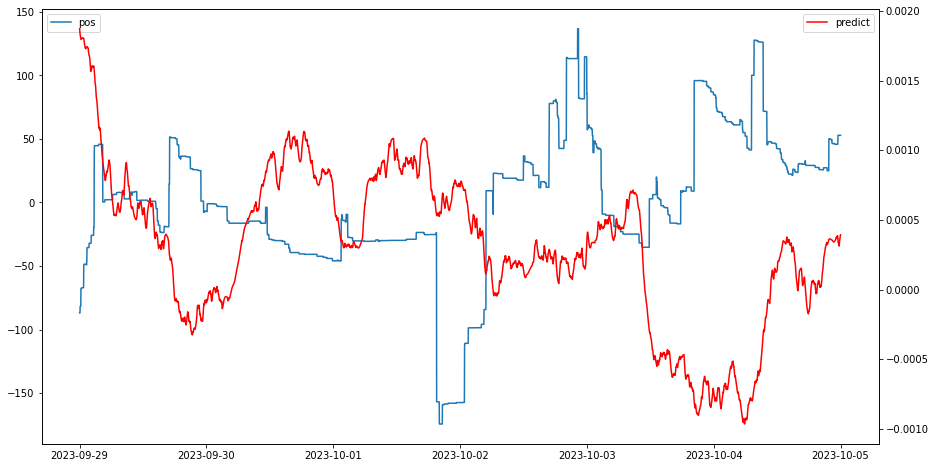

In [80]:
fig, ax1 = plt.subplots(figsize = (15, 8 ))
ax1.plot(df1.time, df1['begin'], label = 'pos')
plt.legend(loc = 'upper left')
ax2 = ax1.twinx()  
ax2.plot(df1.time, df1['predict'], color = 'red', label = 'predict')
plt.legend()
print('corr: ', df1.corr().loc['begin', 'predict'])

## binance实盘与模拟对比

In [4]:
def calculator(df, columns):
    weighted_sum = (df[columns[0]]*df[columns[1]]).sum()/df[columns[1]].sum()
    asum = df[columns[1]].sum()
    fee = df['fee'].sum()
    return pd.Series([weighted_sum,asum,fee], index=['price','ch','fee'])

def get_tom_re():
    dt = []
    for file in os.listdir(r'C:\Users\杜威\Desktop\tardis\Tom_data\bn_trade'):
        df = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/Tom_data/bn_trade/{file}')
        dt.append(df)
    dt = pd.concat(dt)
    dt = dt.drop_duplicates()
    dt['time'] = pd.to_datetime(dt['Time(UTC)']) + timedelta(hours = 8)
    dt = dt.sort_values(by = 'time')
    dt['asset'] = dt['Symbol'].map(lambda x:x[:-4].replace('DOGE','XDG').lower())
    dt['ch'] = dt.apply(lambda x:x['Quantity'] if x['Side'] == 'BUY' else x['Quantity']*(-1),axis = 1)
    dt['fee'] = dt.apply(lambda x:x['Amount'] * 0.000155 if x['Maker'] == False else x['Amount'] * 0.00005 * (-1),axis = 1)
    dt = dt[['time','asset','Side','Price','ch','fee','Amount']]
    dt.rename(columns = {'Price':'price'},inplace = True)
    return dt

In [5]:
re = get_tom_re()

In [6]:
def cal_mean_price(raw):
    depth = abs(raw['ch'])
    if depth == 0:
        return 0
    if raw['ch'] <= 0:
        side = 'ask'
    else:
        side = 'bid'
    value = 0
    amount = 0
    for k in range(25):
        value += raw[f'{side}s[{k}].price'] * raw[f'{side}s[{k}].amount']
        amount += raw[f'{side}s[{k}].amount']
        while amount > depth:
            price = (value - raw[f'{side}s[{k}].price'] * raw[f'{side}s[{k}].amount'] + 
                    (depth - amount + raw[f'{side}s[{k}].amount']) * raw[f'{side}s[{k}].price']) / depth
            return price
    price = (value + (depth - amount) * raw[f'{side}s[{k}].price']) / depth
    return price

def cal_min_price(raw):
    if raw['ch'] <= 0:
        side = 'ask'
    else:
        side = 'bid'
    price = raw[f'{side}s[0].price']
    return price

In [7]:
ex_ls = ['kraken_formal']
part_ls = ['9']
final = []
global lim
global pos_bi_now
for ex in ex_ls:
    for coin_part in part_ls:
        balance = balance_map[str(int(coin_part)-2)]
        credit = credit_map[str(int(coin_part)-2)]
        for coin in os.listdir(f'C:/Users/杜威/Desktop/tardis/profit/pos_ch_takeprice/{ex}/{coin_part}'):
            coin = coin[:-4]
            coin1 = coin[:-4].replace('DOGE','XDG').lower()
            lim = (balance[f'{ex}'][f'{coin1}'] + credit[f'{ex}'][f'{coin1}']) * 0.3
            pos_bi_now = 0
            df = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/profit/pos_ch_takeprice/{ex}/{coin_part}/{coin}.csv')
            df['pos'] = df['pos'].apply(pos_choose)
            df.loc[:1,'pos'] = 0
            df['pos_'] = df['pos'].shift(-1).fillna(0)
            df['ch'] = df['pos_'] - df['pos']
            df['full_price'] = df.apply(cal_mean_price,axis = 1)
            df['min_price'] = df.apply(cal_min_price,axis = 1)
            final.append(df)
final = pd.concat(final)
final = final[['time','asset','full_price','min_price','ch','pos','fp']]
final['ch'] *= -1
final['Side'] = final['ch'].map(lambda x:'BUY' if x >= 0 else "SELL")
#final['ch'] = abs(final['ch'])
final['fee'] = abs(final['ch']) * final['full_price'] * 0.000155
final['time'] = pd.to_datetime(final['time'])

In [11]:
def clean_compara(coin, re, final):
    tt = final[final['asset'] == coin]
    df = re[re['asset'] == coin]
    tt = tt[tt['ch'] != 0]
    begin = (tt['time'] + timedelta(seconds = 100)).values[0]
    end = (tt['time'] + timedelta(seconds = 100)).values[-2]
    df = df[df['time'] >= begin]
    df = df[df['time'] <= end]
    begin = (df['time'] + timedelta(seconds = -60)).values[0]
    end = (df['time'] + timedelta(seconds = 100)).values[-1]
    tt2 = tt[tt['time'] >= begin][tt['time'] <= end]
    return df, tt, tt2

In [14]:
def profit_calculate(dt, name):
    if name == 'real':
        P = 'price'
    else:
        P = name.replace('_NoFee', '')
    dt['pos'] = dt['ch'].cumsum()
    dt['asset'] = -1 * (dt['ch'] * dt[P]).cumsum()
    dt['fee_s'] = dt['fee'].cumsum()
    dt['coin value'] = dt['pos'] * dt[P]
    if 'NoFee' in name:
        dt['profit'] = dt['asset'] + dt['coin value']
    else:
        dt['profit'] = dt['asset'] + dt['coin value'] - dt['fee_s']
    dt['diff'] = dt['profit'].diff()
    return dt, dt['profit'].values[-1]

In [16]:
def plot_compara_coin(re, final, coin, fig):
    df, tt, tt2 = clean_compara(coin, re, final)
    for dt, name in zip([df, tt2, tt2, tt2], ['real', 'full_price', 'min_price', 'min_price_NoFee']):
        dt = profit_calculate(dt, name)[0]
        fig.add_trace(
            go.Scatter(
                x = dt['time'],
                y = dt['diff'],
                mode = 'lines',
                name = f'{coin}_{name}'
            )
        )

def plot_compara_all(re, final):
    layout = go.Layout(
        title=f'binance_compara',
        xaxis=dict(title='time'),
        yaxis=dict(title='profit')
        )
    fig = go.Figure(layout=layout)
    for coin in set(final['asset']):
        plot_compara_coin(re, final, coin, fig)
    path = f'C:/Users/杜威/Desktop/tardis/profit/new x/compara_real/plot'
    os.chdir(path)
    plotly.offline.plot(fig, filename=f'binance_compara_diff.html', auto_open=False)

In [17]:
plot_compara_all(re, final)

In [34]:
coin = 'link'
left = '2023-11-18 15:00:00'
right = '2023-11-18 15:01:00'

In [35]:
final[(final['asset'] == coin) & (final['time'] >= left) &(final['time'] <= right) & (final['ch'] != 0)]

,time,asset,full_price,min_price,ch,pos,fp,Side,fee
769,2023-11-18 15:00:23.026,link,13.070944,13.077,-7369.717232,-4157.407366,13.081852,SELL,14.931019


In [36]:
re[(re['asset'] == coin) & (re['time'] >= left) &(re['time'] <= right)]

,time,asset,Side,price,ch,fee,Amount
48862,2023-11-18 15:00:24,link,SELL,13.086,-148.34,0.300882,1941.17724
48863,2023-11-18 15:00:24,link,SELL,13.086,-371.82,0.754174,4865.63652
48864,2023-11-18 15:00:24,link,SELL,13.084,-8.29,0.016812,108.46636
48865,2023-11-18 15:00:24,link,SELL,13.086,-3.81,0.007728,49.85766
48866,2023-11-18 15:00:24,link,SELL,13.086,-47.17,0.095676,617.26662
48867,2023-11-18 15:00:30,link,SELL,13.088,-12.11,-0.007925,158.49568
48868,2023-11-18 15:00:31,link,SELL,13.093,-0.14,-0.000092,1.83302
48869,2023-11-18 15:00:31,link,SELL,13.093,-2.64,-0.001728,34.56552
48870,2023-11-18 15:00:32,link,SELL,13.095,-23.88,-0.015635,312.70860
48871,2023-11-18 15:00:36,link,SELL,13.101,-151.37,-0.099155,1983.09837


In [25]:
def pp(df,tt,begin,end):
    df2 = df[:]
    tt2 = tt[:]
    p1 = (df2['price'] * df2['ch']).sum()*(-1)
    p2 = (tt2['price'] * tt2['ch']).sum()*(-1)
    return round(p1,2),round(p2,2)

In [26]:
pp(df,tt2,begin,end)

(-402426.14, -296916.51)

In [5]:
def get_profit(df):
    df['profit'] = df['price'] * df['ch']
    price_end = df['price'].values[-1]
    return [df['profit'].sum()* (-1), df['profit'].sum()* (-1) - df['fee'].sum()]
def all_diff():
    amount_taker = []
    amount_maker = []
    b0 = []
    b = []
    for coin in ['ada','btc','xdg','dot','eth','link','ltc','matic','sol','xrp']:
        tt = final[final['asset'] == coin]
        df = re[re['asset'] == coin]
        tt = tt[tt['ch'] != 0]
        begin = (tt['time'] + timedelta(seconds = 100)).values[0]
        if coin == 'link':
            begin = (tt['time'] + timedelta(seconds = 100)).values[3]
        end = (tt['time'] + timedelta(seconds = 100)).values[-2]
        df = df[df['time'] >= begin]
        df = df[df['time'] <= end]
        begin = (df['time'] + timedelta(seconds = -60)).values[0]
        end = (df['time'] + timedelta(seconds = 100)).values[-1]
        p2 = round(get_profit(tt)[1],2)
        tt2 = tt[tt['time'] >= begin][tt['time'] <= end]
        profit = round(get_profit(df)[1] + p2 - get_profit(tt2)[1],2)
        amount_taker.append(df[df['fee'] >= 0]['Amount'].sum())
        amount_maker.append(df[df['fee'] <= 0]['Amount'].sum())
        b0.append(round(get_profit(df)[0] + p2 - get_profit(tt2)[1],2))
        b.append(profit)
    for t in [amount_taker,amount_maker,b0,b]:
        t.append(sum(t))
    df = pd.read_csv(r'C:\Users\杜威\Desktop\tardis\profit\new x\ch\kraken_formal_9.csv')
    df['real'] = b
    df['real No fee'] = b0
    df['amount_maker'] = amount_maker
    df['amount_taker'] = amount_taker
    return df

In [22]:
all_diff()

,Unnamed: 0,coin,fp_kk,No Fee,Fully hedged min price,Fully hedged change price,strategy min price,strategy change price,real,real No fee,amount_maker,amount_taker
0,0,ada,100845.10,74518.53,68022.39,58982.12,-66650.72,-82289.04,-85111.53,-85864.77,1.616414e+07,3.546497e+05
1,1,btc,-7311.26,-31979.98,-77627.82,-85290.06,-46398.17,-56053.42,-100578.53,-106567.55,1.206941e+08,2.947342e+05
2,2,xdg,24493.62,-4666.55,-10550.90,-15192.89,-13856.40,-21233.46,-24015.34,-24708.95,1.620522e+07,7.525772e+05
3,3,dot,20732.62,8872.55,6809.77,5054.84,23811.80,19806.37,21363.23,21028.52,7.193939e+06,1.611793e+05
4,4,eth,-7708.90,-28504.51,-48280.93,-53761.85,-227978.07,-234743.41,-233269.67,-236059.01,5.623242e+07,1.437216e+05
5,5,link,29250.43,3037.47,-2228.63,-8042.46,-21820.82,-31235.31,-22666.61,-23485.53,1.692344e+07,1.758388e+05
6,6,ltc,-19.69,-8117.14,-9565.25,-10272.65,-9628.27,-11208.48,-10517.18,-10744.89,5.149583e+06,1.921019e+05
7,7,matic,8782.00,-7666.78,-11477.86,-15266.20,-22247.63,-28957.28,-27035.49,-27596.03,1.260513e+07,4.498285e+05
8,8,sol,35034.58,-32228.07,-66286.69,-109349.65,-148057.72,-181585.28,-268322.66,-272745.64,9.272577e+07,1.376206e+06
9,9,xrp,3433.40,-23166.22,-27358.43,-29460.79,-11265.29,-15497.79,-12604.62,-13023.77,1.073086e+07,7.573915e+05


In [377]:
all_diff().to_csv(r'C:\Users\杜威\Desktop\tardis\profit\new x\compara_real\kraken_formal_9_1.csv')

In [9]:
begin = '2023-10-31'
end = '2023-11-09'

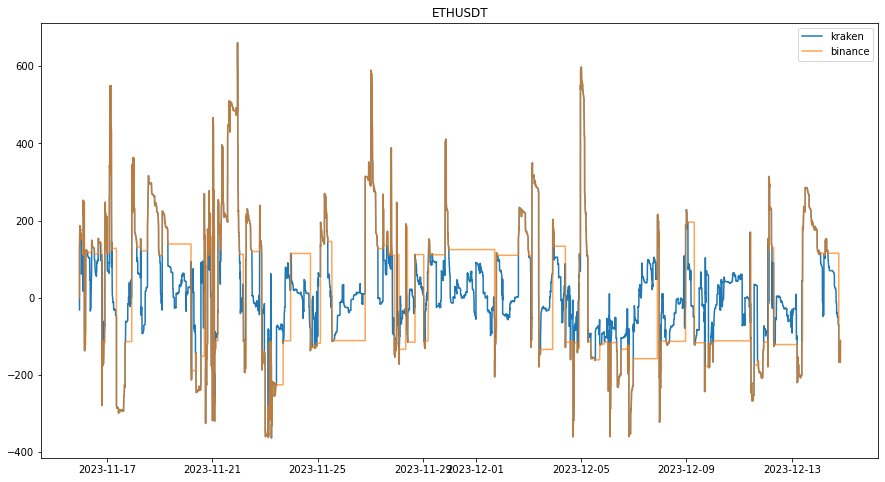

In [44]:
coin1 = 'eth'
coin = 'ETHUSDT'
tt = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/profit/pos_ch_takeprice/kraken_formal/9/{coin}.csv')
#df['time'] = pd.to_datetime(df['time'])
tt['time'] = pd.to_datetime(tt['time'])
tt = tt[tt['time'] >= begin][tt['time'] <= end]
tt2 = final[final['asset'] == coin1]
tt2 = tt2[tt2['time'] >= begin][tt2['time'] <= end]
plt.figure(figsize=(15, 8))
plt.plot(tt['time'],tt['pos'],label = 'kraken')
plt.plot(tt2['time'],tt2['pos'],label = 'binance',alpha = 0.7)
plt.title(f'{coin}')
plt.legend()

In [2]:
def get_begintime(ex, part, coin):
    ch = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/profit/先进后出/kraken_formal/5/btc.csv')
    t1 = ch[['open_time','asset']].groupby('open_time',as_index = False).first().rename(columns = {'open_time':'time'})
    t2 = ch[['close_time','asset']].groupby('close_time',as_index = False).first().rename(columns = {'close_time':'time'})
    t = t1.append(t2).sort_values(by = 'time').groupby('time',as_index = False).first()
    return t['time'].values[0],t['time'].values[-1]

# tardis down

In [2]:
coin_ls = ['SOLUSDT','MATICUSDT','DOTUSDT','DOGEUSDT','LTCUSDT','XRPUSDT','ADAUSDT','LINKUSDT','BTCUSDT','ETHUSDT']

In [2]:
coin = 'ADAUSDT'

In [14]:
datasets.download(
            exchange='binance-futures',
            data_types=[
                'book_snapshot_25'
            ],
            from_date='2023-08-31',
            to_date='2023-09-01',
            symbols=[coin],
            api_key=secret,
        )

In [20]:
ob = pd.read_csv(r'C:\Users\杜威\Desktop\2023-06-01.gz')

In [9]:
ob['mp'] = (ob['asks[0].price'] + ob['bids[0].price']) / 2
ob['dist'] = ob['asks[1].price'] / ob['mp'] - 1

In [10]:
ob['dist']

0          0.000566
1          0.000566
2          0.000566
3          0.000566
4          0.000566
             ...   
1112768    0.000588
1112769    0.000588
1112770    0.000588
1112771    0.000588
1112772    0.000588
Name: dist, Length: 1112773, dtype: float64

In [32]:
f_gettime = lambda x: datetime.fromtimestamp((x) / 1000000)  ##get datatime_type
ob['time'] = ob.timestamp.map(f_gettime)

In [106]:
df = ob[:]

In [27]:
def clean_25(df, gap = 's'):
    f_gettime = lambda x: datetime.fromtimestamp((x) / 1000000)  ##get datatime_type
    df['time'] = df.timestamp.map(f_gettime)
    df['time'] = df['time'].dt.floor(gap)
    df = df.groupby('time', as_index=False).mean().dropna()
    df['mp'] = (df[f'asks[0].price'] + df[f'bids[0].price']) / 2
    ls = ['time']
    df['value_-1'] = 0
    df['amount_-1'] = 0
    for i in range(25):
        df[f'value_{i}'] = df[f'value_{i-1}'] + df[f'{side}s[{i}].price'] * df[f'{side}s[{i}].amount']
        df[f'amount_{i}'] = df[f'amount_{i-1}'] + df[f'{side}s[{i}].amount']
        df[f'dist_{i}'] = df[f'{side}s[{i}].price'] / df[f'mp'] - 1
        ls.append(f'{side}s[{i}].price')
        for name in ['value','dist']:
            ls.append(f'{name}_{i}')
    df = df[ls]
    return df

In [38]:
df = clean_25(df)

In [43]:
    f_gettime = lambda x: datetime.fromtimestamp((x) / 1000000)  ##get datatime_type
    df['time'] = df.timestamp.map(f_gettime)
    df['time'] = df['time'].dt.floor('s')
    df = df.groupby('time', as_index=False).mean().dropna()
    df['mp'] = (df[f'asks[0].price'] + df[f'bids[0].price']) / 2
    del df[f'bids[0].price']
    del df['timestamp']

In [112]:
def mid_dist(df, coin, side, gap = 's'):
    f_gettime = lambda x: datetime.fromtimestamp((x) / 1000000)  ##get datatime_type
    df['time'] = df.timestamp.map(f_gettime)
    df['time'] = df['time'].dt.floor(gap)
    df = df.groupby('time', as_index=False).mean().dropna()
    df['mp'] = (df[f'asks[0].price'] + df[f'bids[0].price']) / 2
    del df['timestamp']
    if side == 'ask':
        del df[f'bids[0].price']
    else:
        del df[f'asks[0].price']
    depth_ls = [12500, 25000, 50000, 100000, 200000]
    if coin in ['BTCUSDT', 'ETHUSDT']:
        depth_ls = [50000, 100000, 200000, 400000, 800000]
    arr = df.values
    records = np.empty((len(arr), 11), dtype=object)
    for i in range(len(arr)):
        col = arr[i]
        value_ls = [col[0]]
        value = 0
        amount = 0
        num = 0
        depth = depth_ls[num]
        for k in range(1,26):
            value += col[2*k-1]*col[2*k]
            amount += col[2*k]
            while value > depth:
                max1 = col[2*k-1] / col[51] - 1
                mean1 = depth / ((depth - value + col[2*k-1]*col[2*k]) / col[2*k-1] + amount - col[2*k]) / col[51] - 1
                max1 = round(max1*10000, 3)
                mean1 = round(mean1*10000, 3)
                value_ls.append(max1)
                value_ls.append(mean1)
                num += 1
                if num >= len(depth_ls):
                    break
                depth = depth_ls[num]
            if num >= len(depth_ls):
                break
        while num < len(depth_ls):
            value_ls.append(np.nan)
            value_ls.append(np.nan)
            num += 1
        record = np.array(value_ls)
        records[i] = record
    
    columns = ['time']
    for i in range(5):
        depth = depth_ls[i]
        columns.append(f'{depth}_max')
        columns.append(f'{depth}_mean')
    df = pd.DataFrame(records, columns=columns)
    return df

In [113]:
df = mid_dist(ob, 'SOLUSDT', 'ask')

In [10]:
df['time'] = df['time'].dt.floor('min')
df = df.groupby('time', as_index=False).mean().dropna()

In [11]:
ob[(ob['time'] >= '2023-08-31 23:59:04') & (ob['time'] <= '2023-08-31 23:59:05')].to_csv(r'C:\Users\杜威\Desktop\datasets\ticker.csv')

##  交易量对盘口价格的影响

In [62]:
def plot_trade(coin, ex):
    df = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/trade_large/ch/{ex}_ch/{coin}.csv')
    df = df.sort_values(by = 'max', ascending = False)
    df1 = df[df['sum'] >= 0]
    df2 = df[df['sum'] <= 0]
    dt = df.iloc[:100,:]
    p = np.polyfit(dt['sum'], dt['ch'], 1)
    y = np.polyval(p, dt['sum'])
    slope = p[0] * 10000 * 10000
    return slope
    slope = round(slope ,3)
    up = max(dt['ch'])
    down = min(dt['ch'])
    up = min(up,-1*down)
    plt.figure(figsize=(15, 8))
    plt.scatter(df1['sum'],df1['ch'],label = 'buy')
    plt.scatter(df2['sum'],df2['ch'],label = 'sell')
    plt.plot(dt['sum'], y, label = f'k = {slope}')
    plt.title(f'{coin}_large_trade')
    plt.xlabel('Dallor Value')
    plt.ylabel(f'Price Change')
    plt.ylim([-1*up,up])
    plt.legend()
    plt.savefig(f'C:/Users/杜威/Desktop/tardis/trade_large/{ex}_plot/{coin}.jpg') 

In [63]:
ex_ls = ['kraken', 'binance-futures', 'binance', 'coinbase']
df = []
for ex in ex_ls[:]:
    p_ls = [ex]
    for coin in coin_ls[:]:
        p = plot_trade(coin, ex)
        p_ls.append(p)
    df.append(p_ls)
c_ls = ['exchange'] + coin_ls
df = pd.DataFrame(df,columns = c_ls)

In [64]:
df.to_csv(f'C:/Users/杜威/Desktop/k.csv')

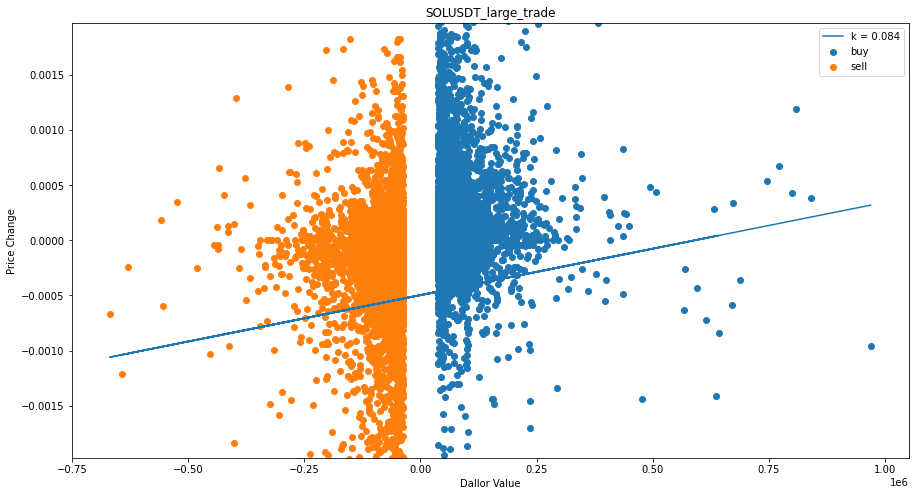

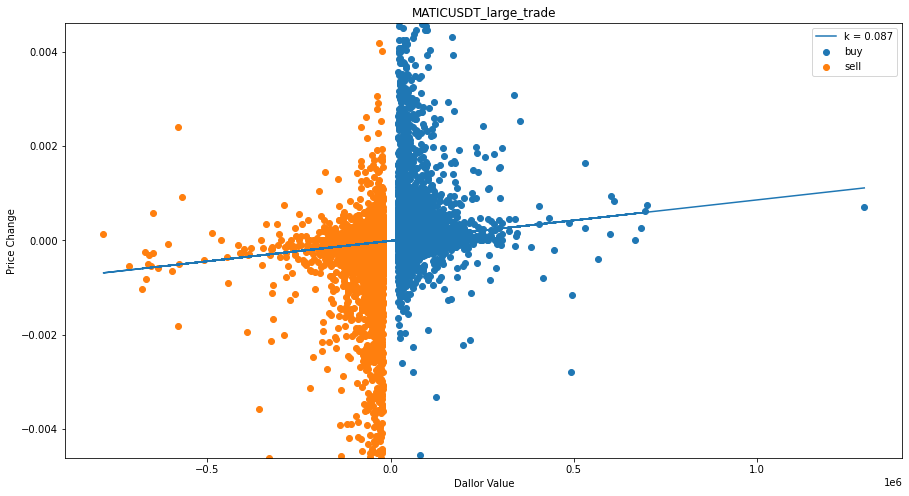

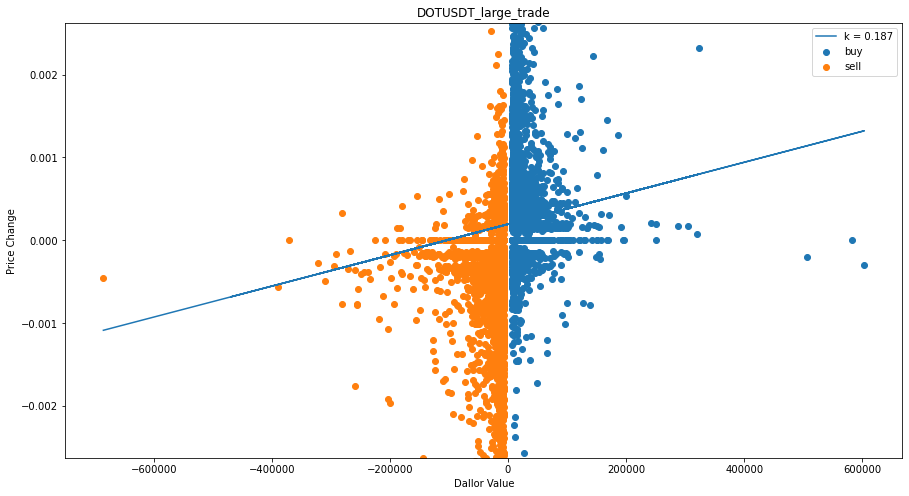

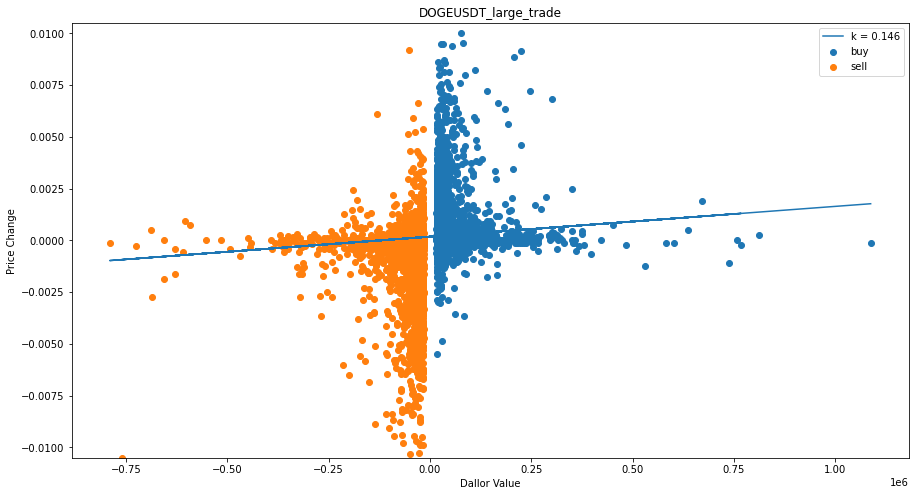

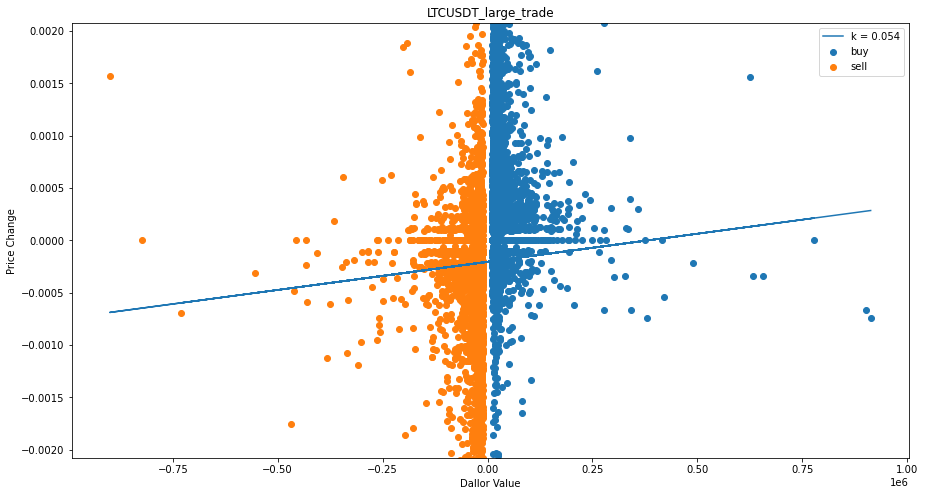

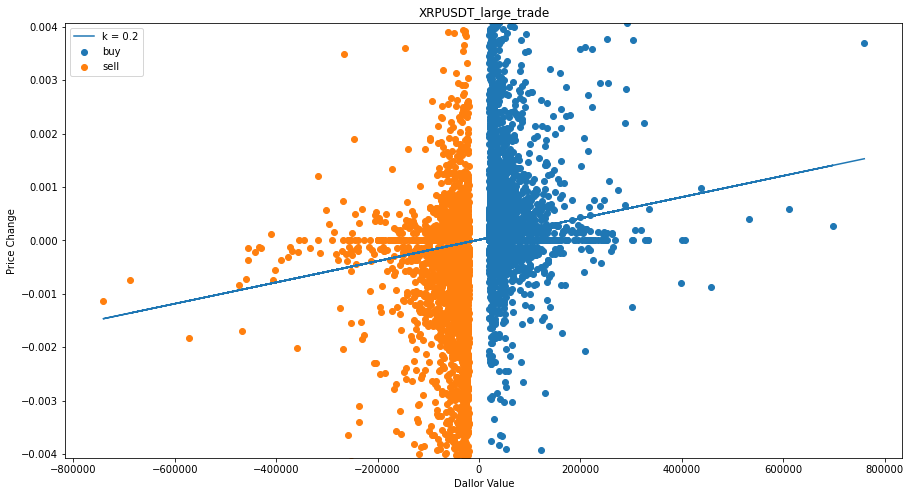

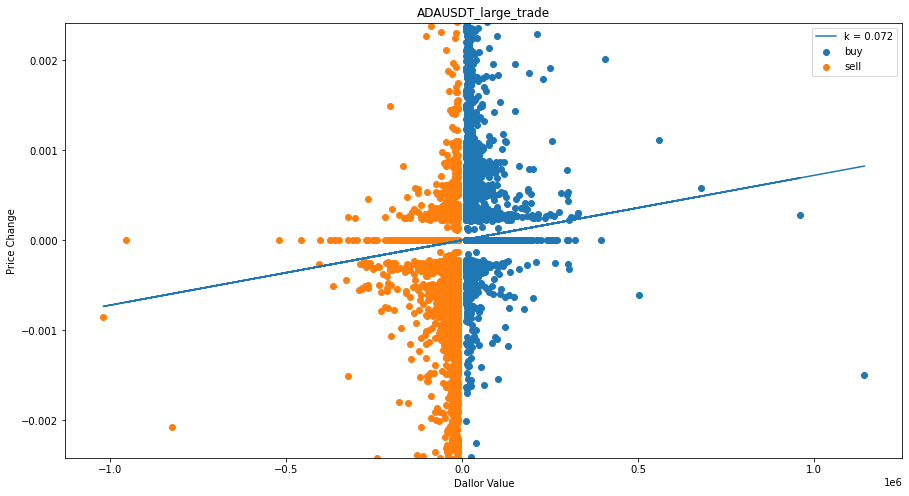

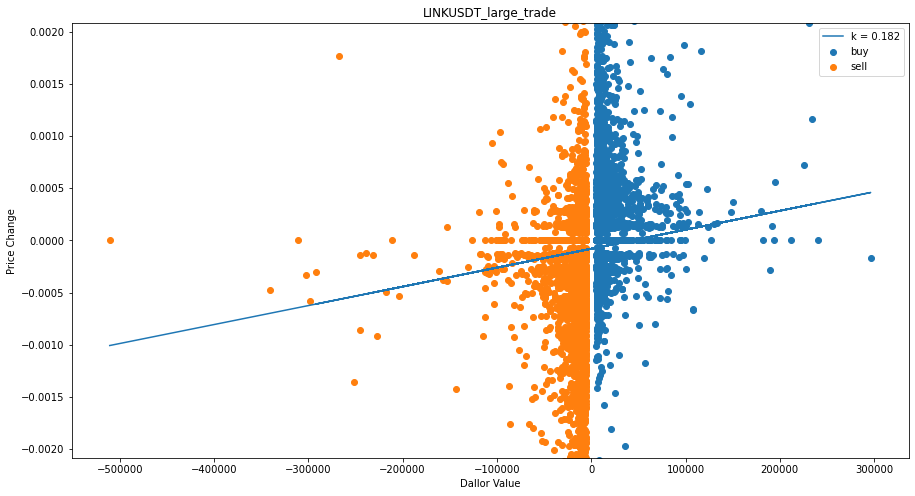

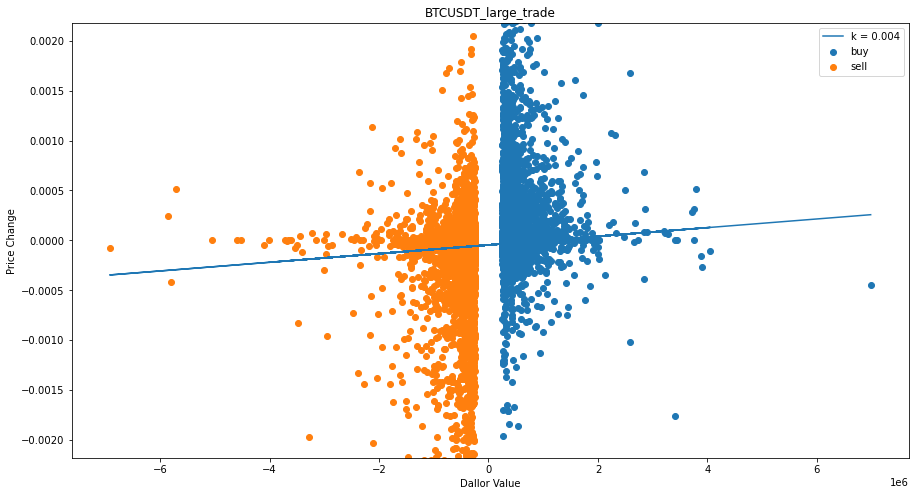

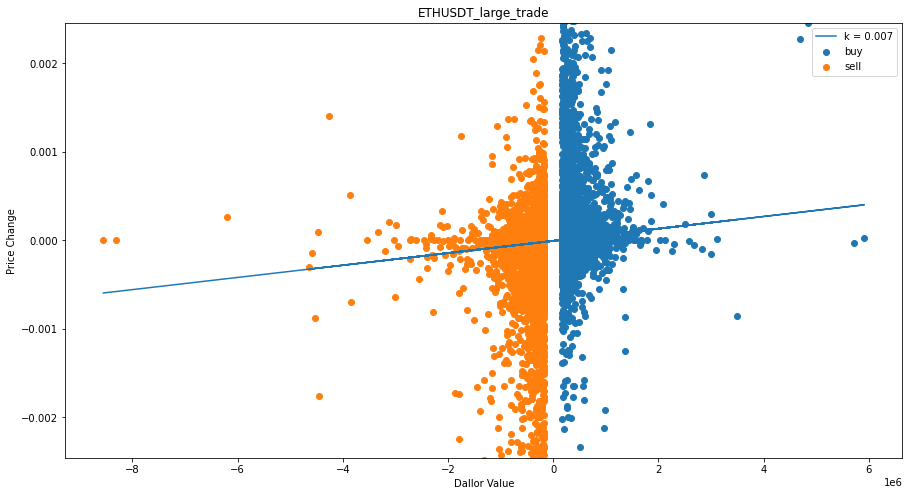

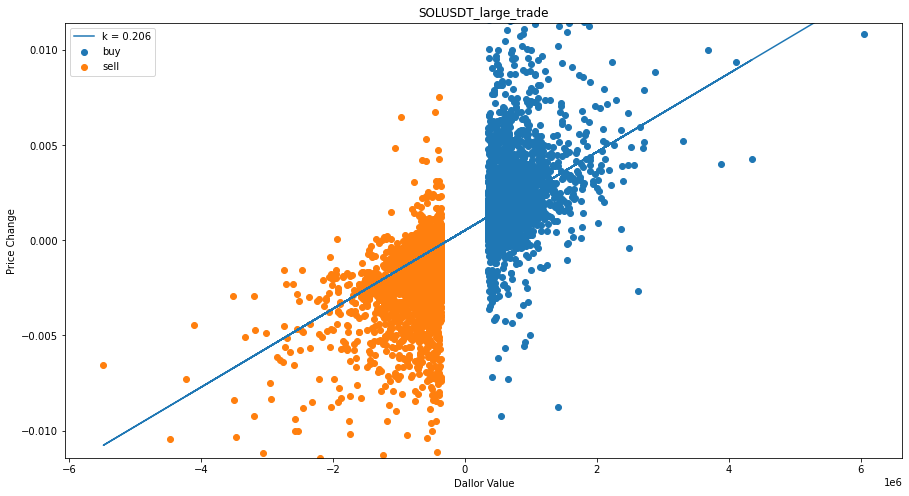

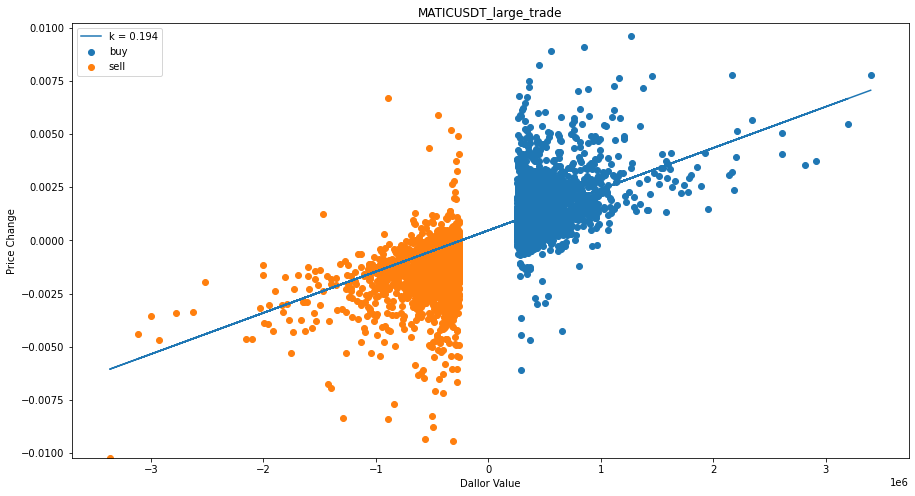

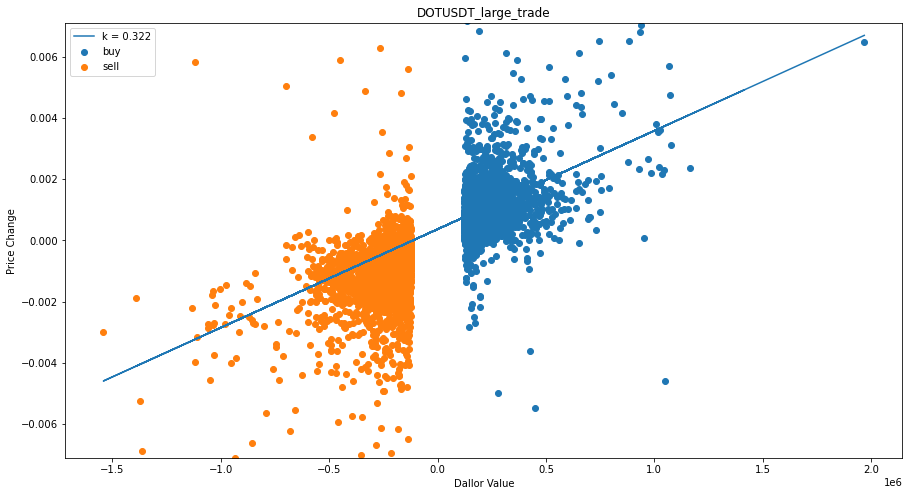

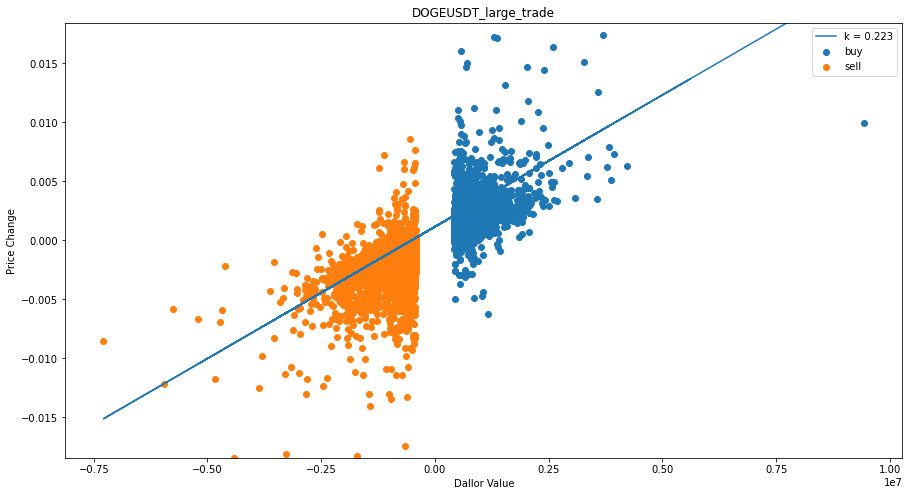

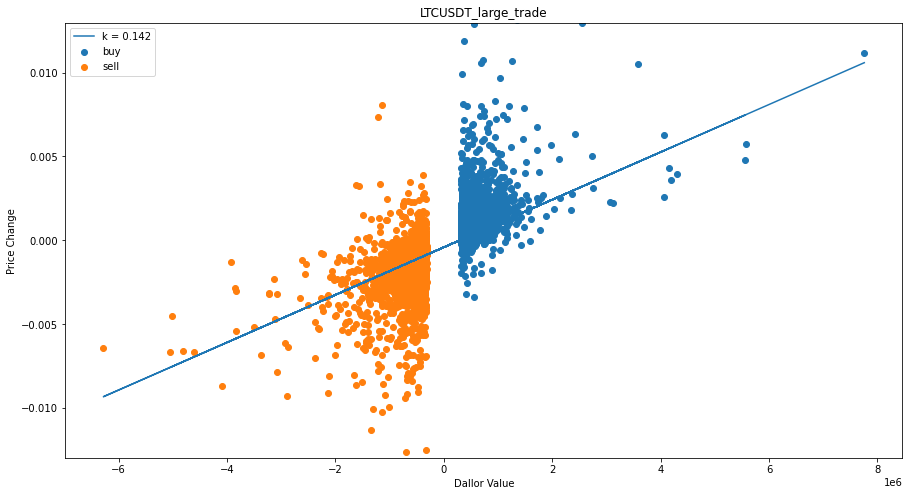

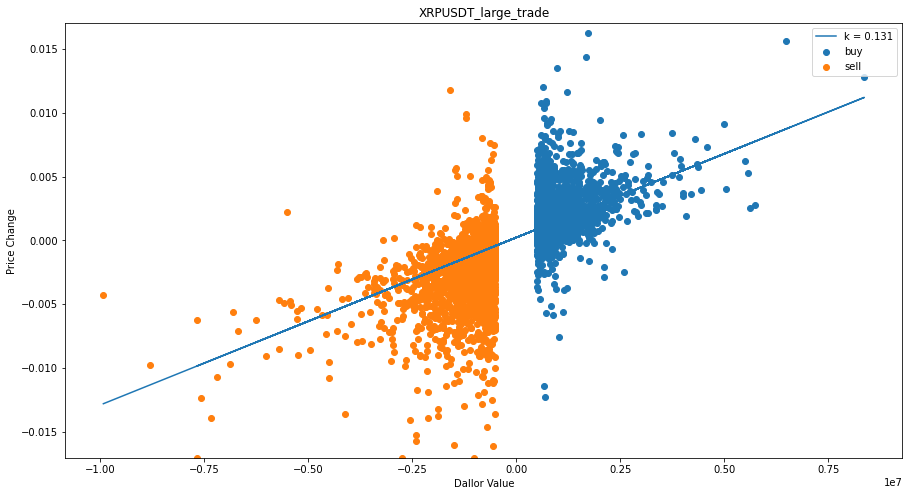

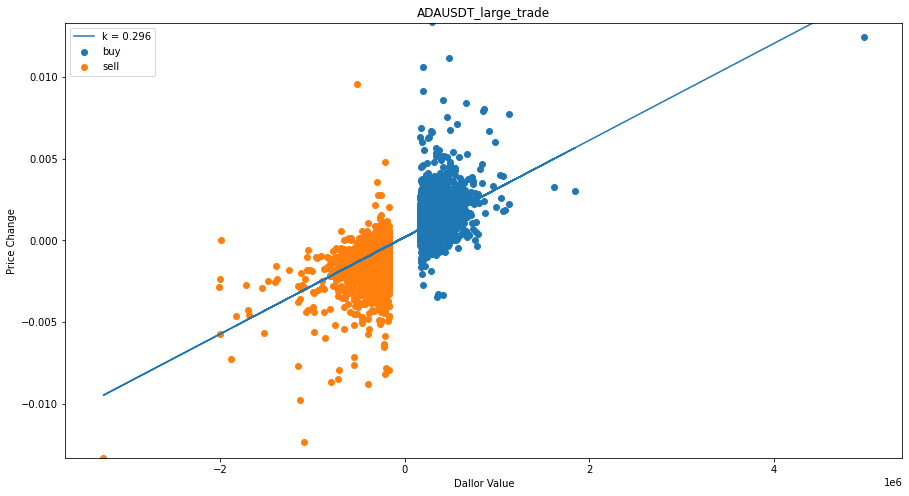

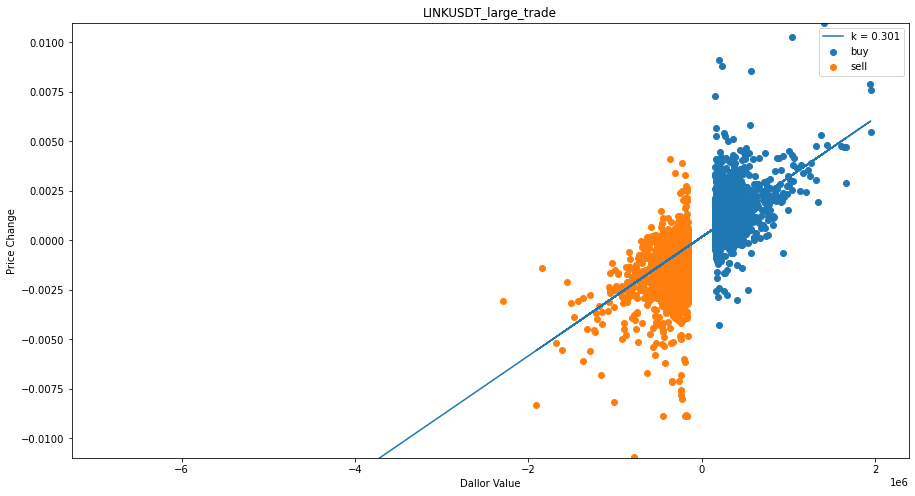

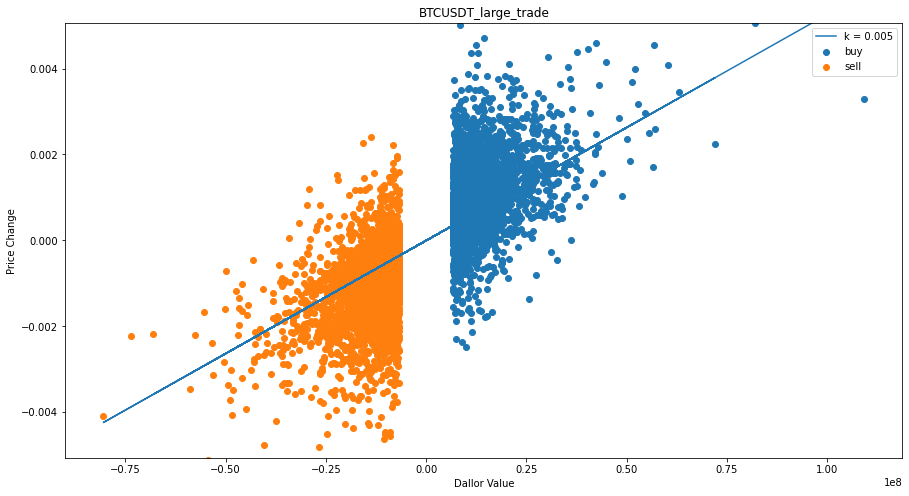

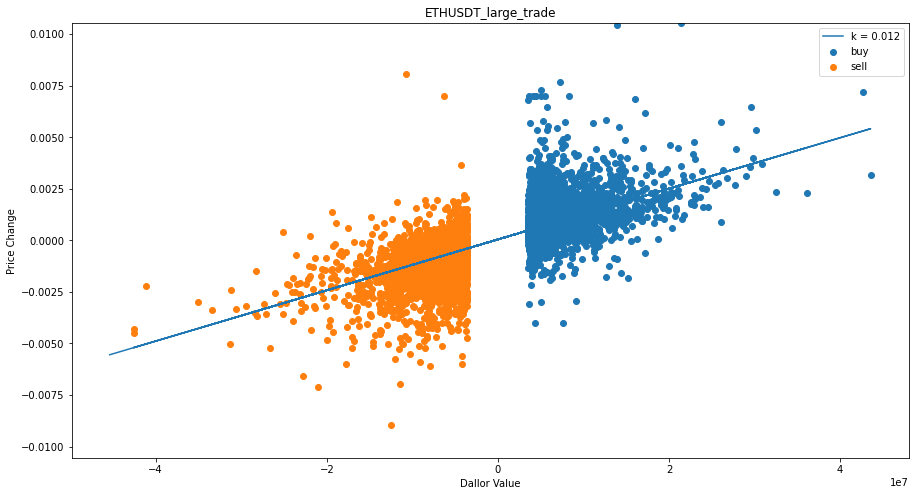

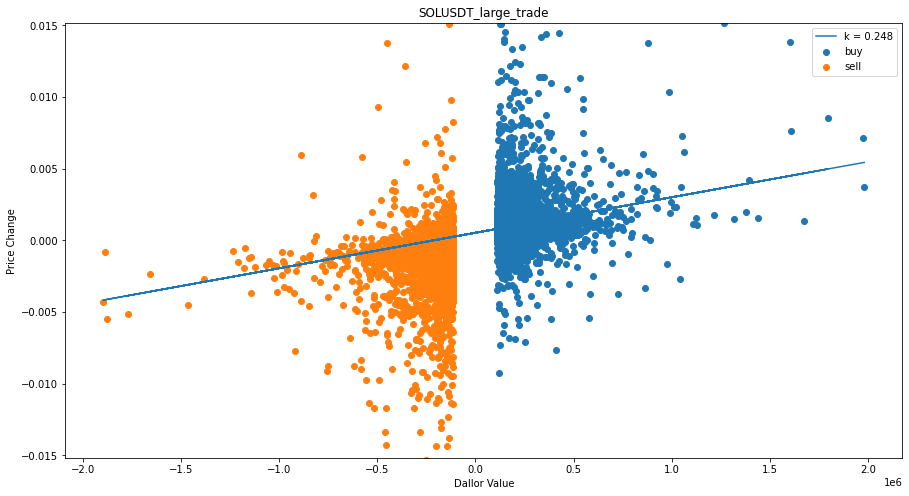

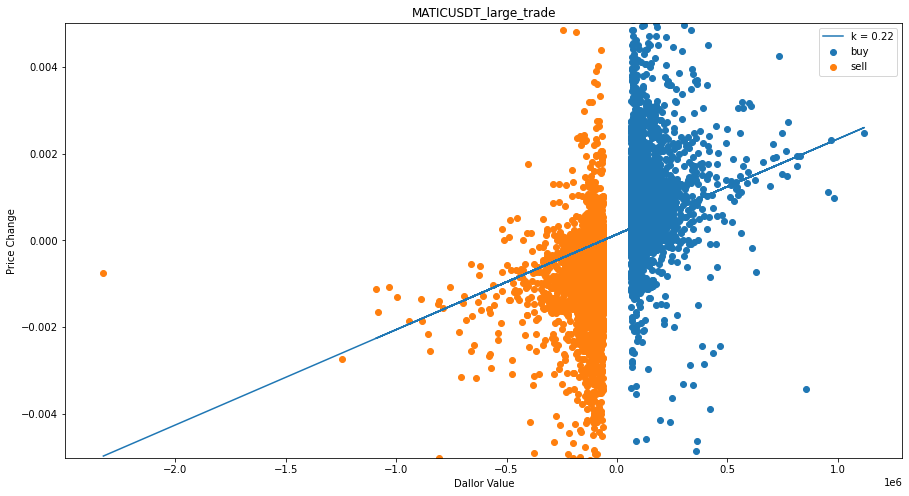

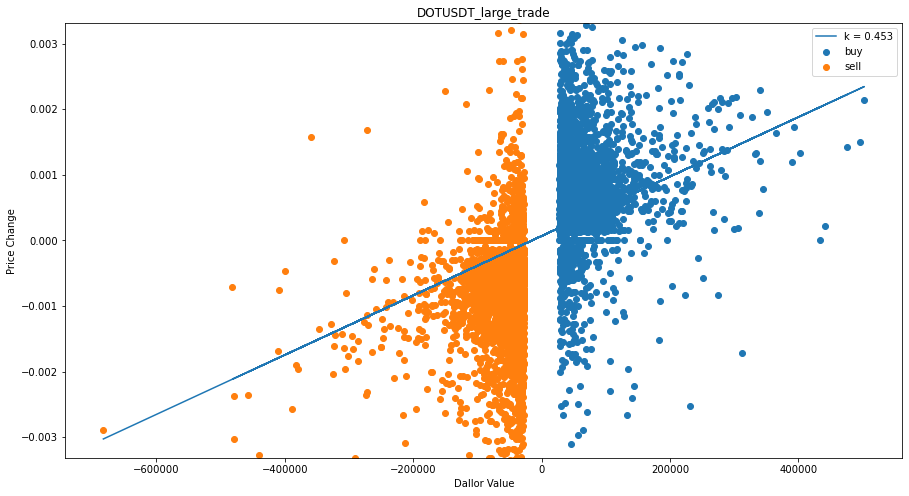

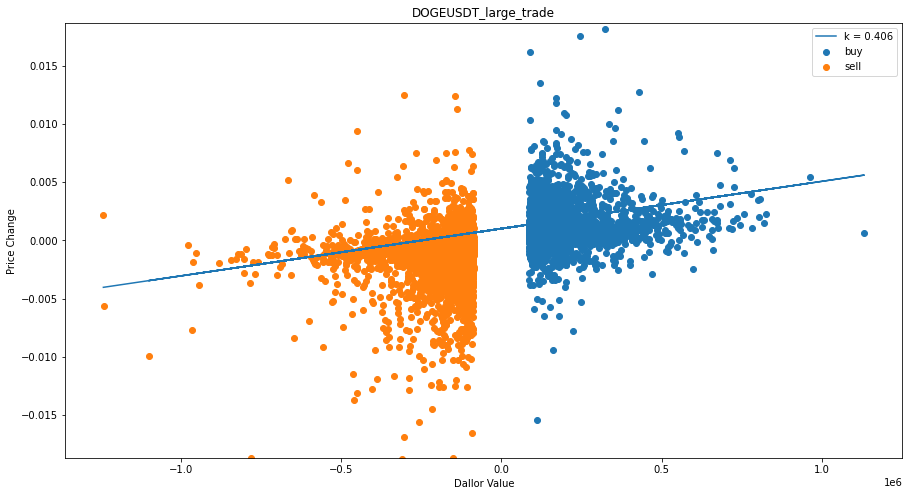

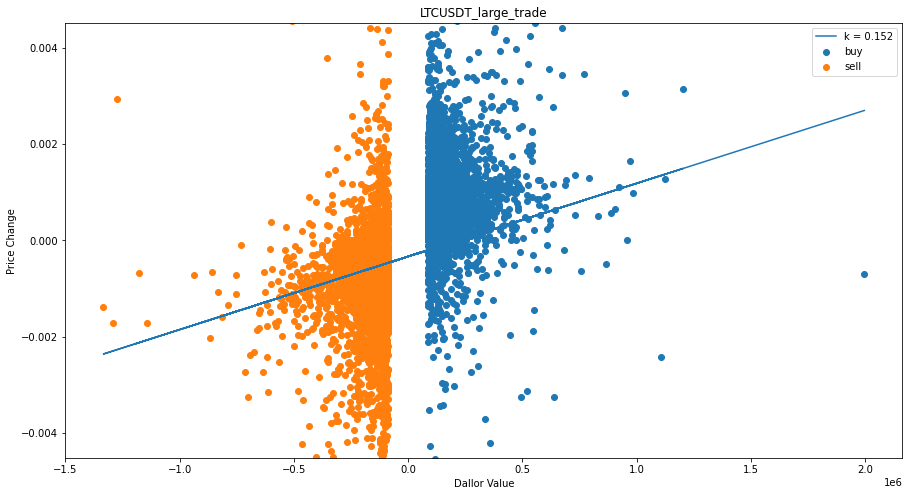

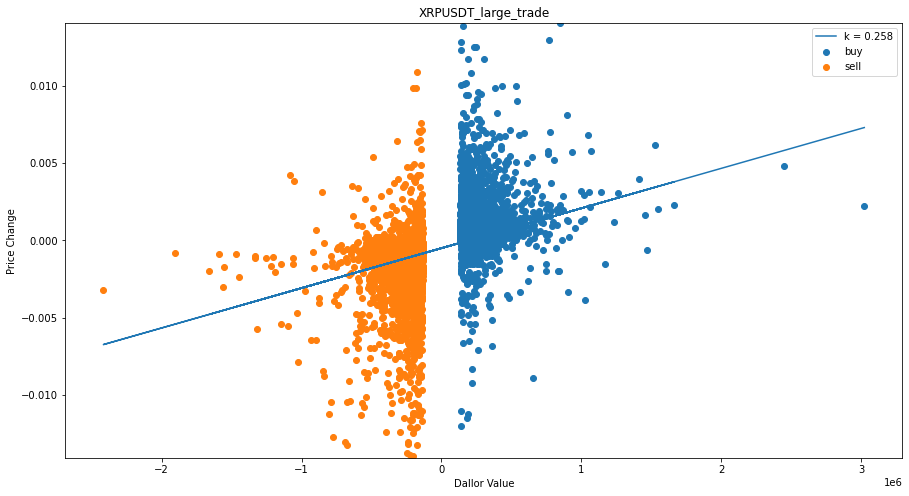

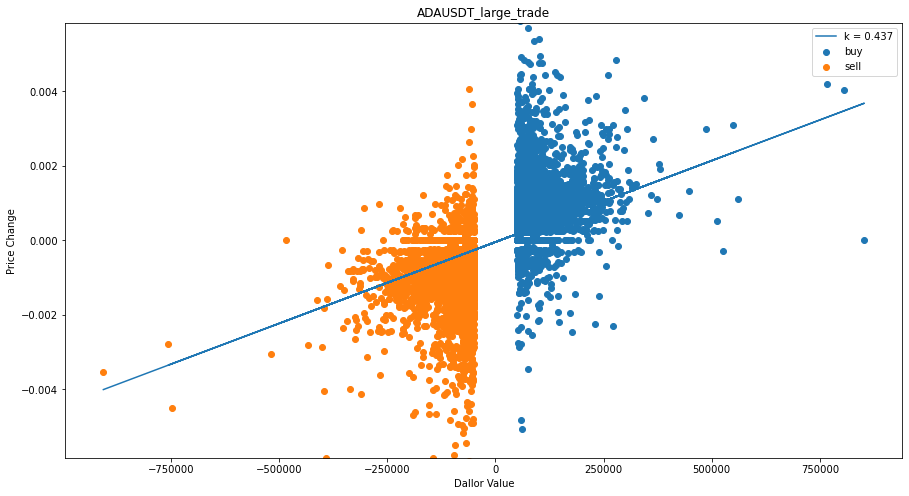

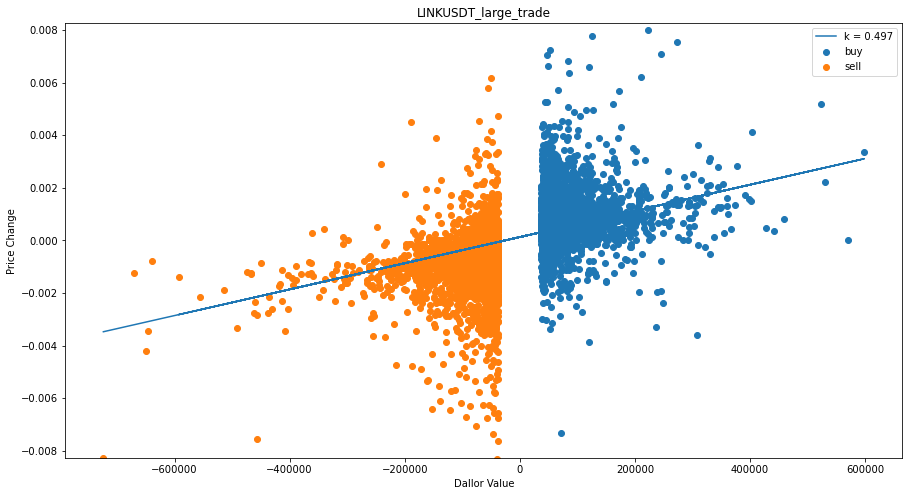

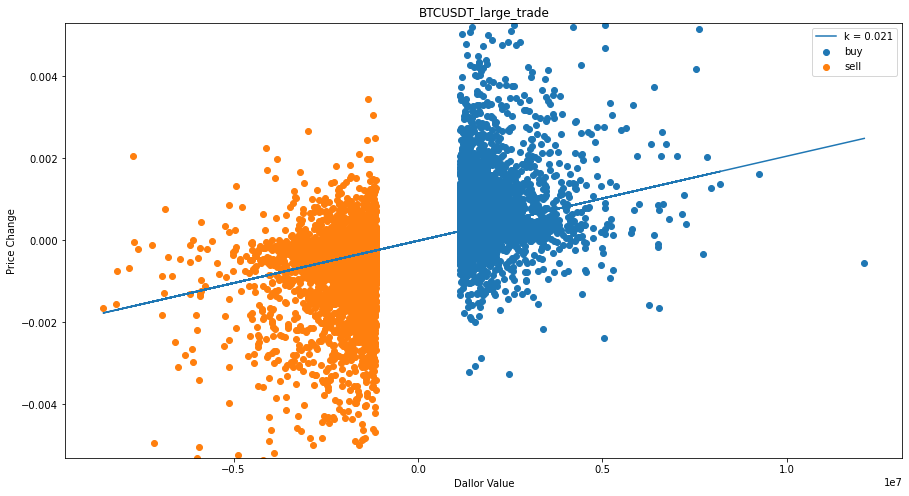

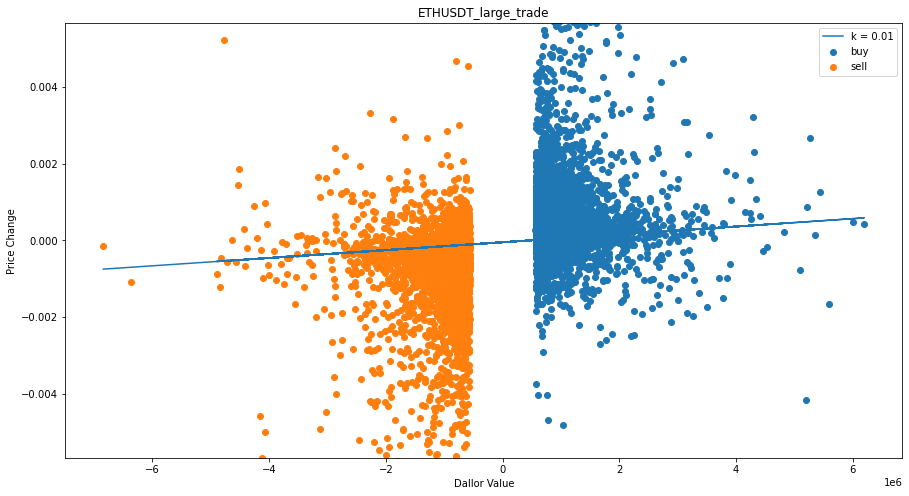

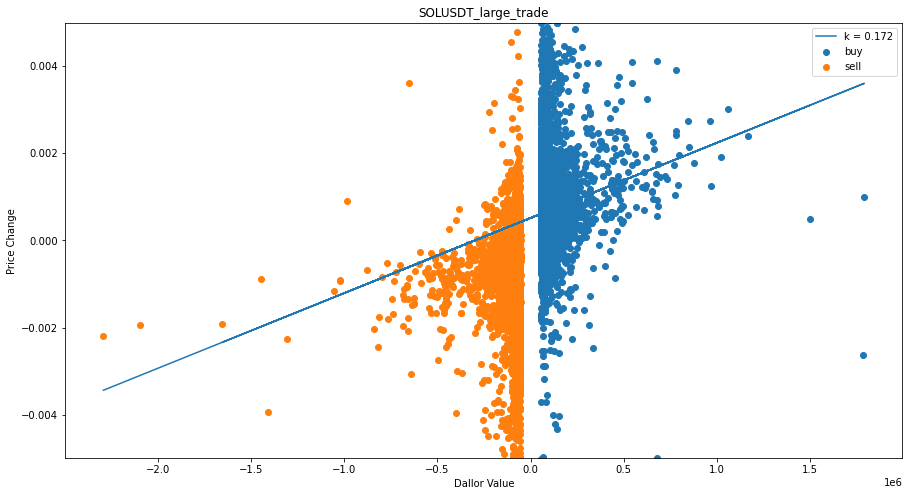

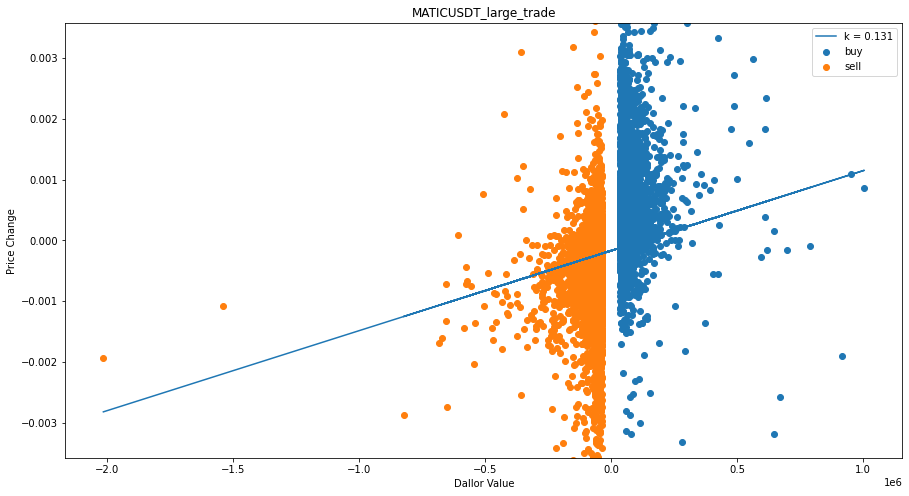

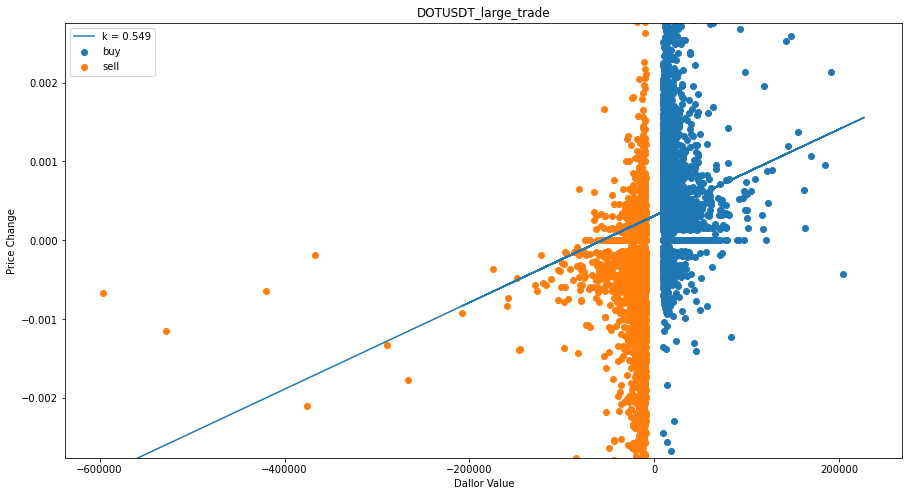

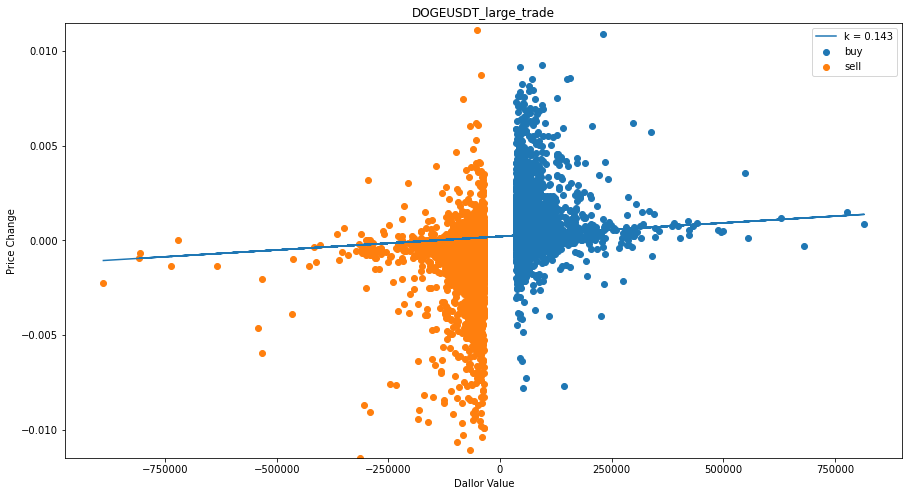

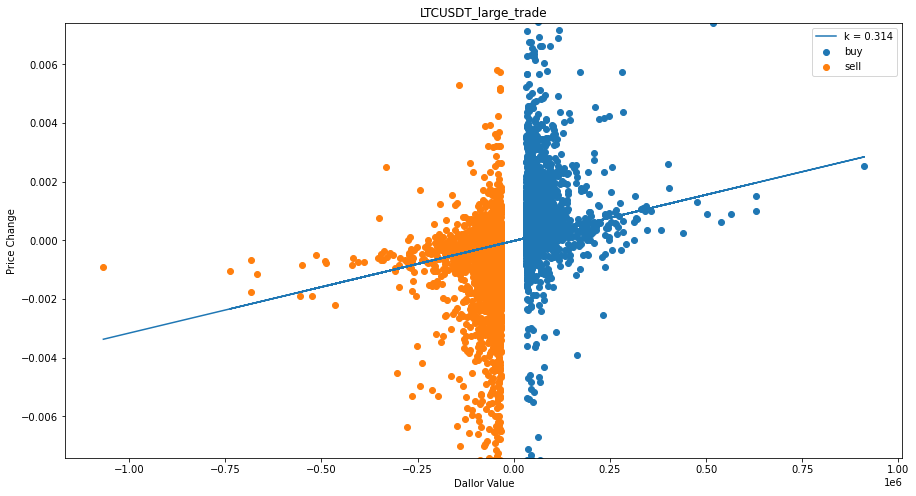

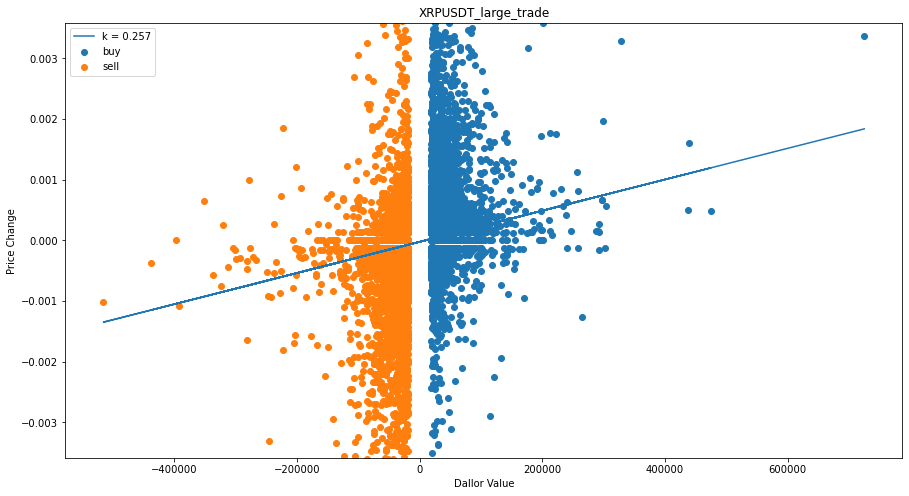

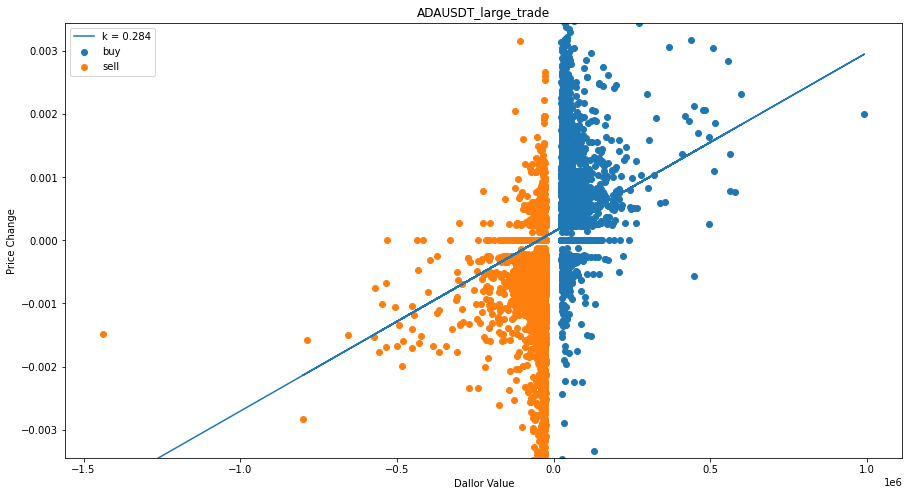

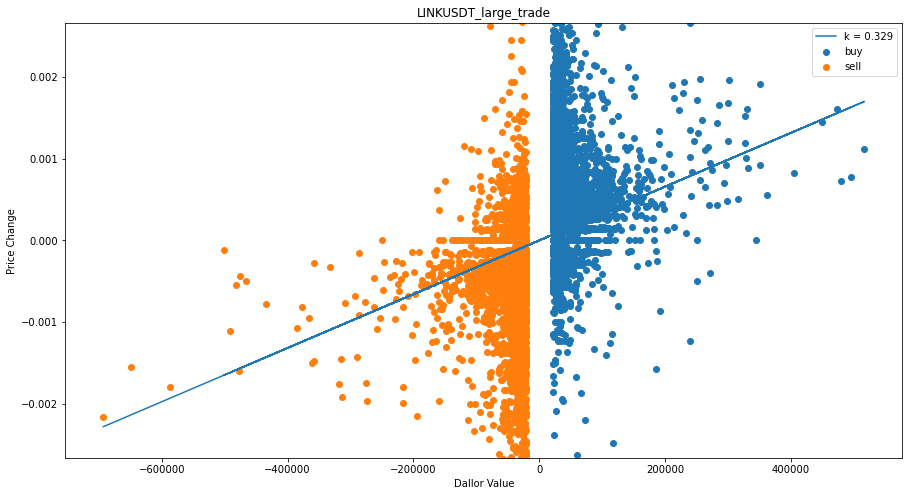

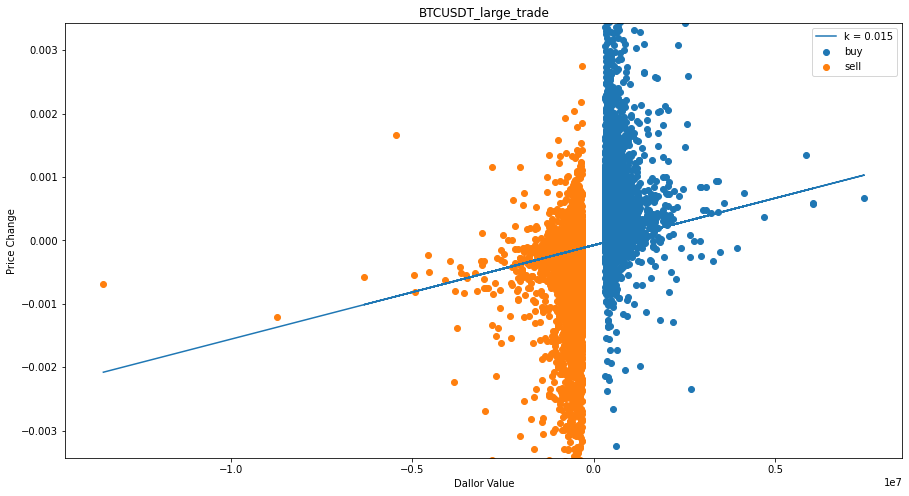

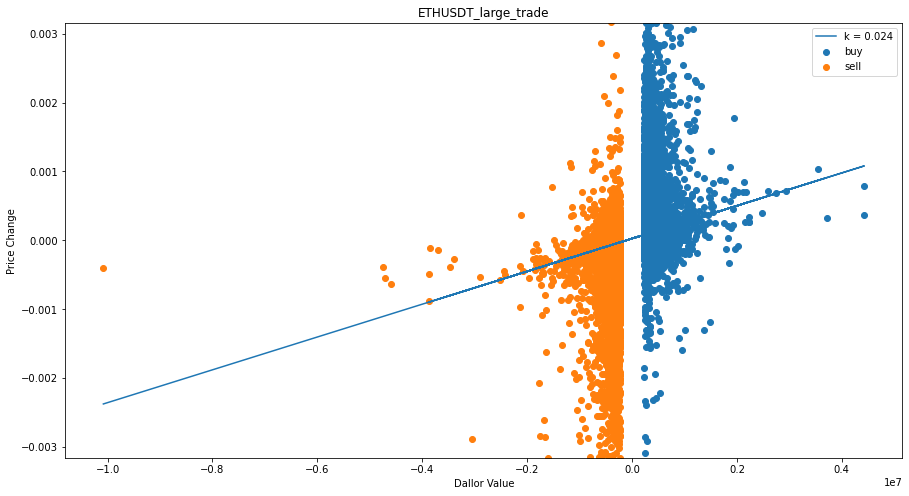

In [95]:
ex_ls = ['kraken', 'binance-futures', 'binance', 'coinbase']
for ex in ex_ls[:]:
    for coin in coin_ls[:]:
        plot_trade(coin, ex)

## 交易所在盘口位置

In [30]:
side = 'ask'
coin = 'ADAUSDT'
df = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/trade_large/min_ob_line/{coin}/{coin}-{side}.csv')

In [65]:
def get_name_p(coin, side):
    df = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/trade_large/min_ob_line/{coin}/{coin}-{side}.csv')
    if coin in ['BTCUSDT', 'ETHUSDT']:
        s = 100000
        b = 500000
    else:
        s = 50000
        b = 200000
    v_ls = []
    d_ls = []
    for col in df.columns:
        if 'value' in col and (df[col][5] >= s and df[col][5] <= b):
            num = col[-1]
            v_ls.append(f'value_{num}')
            d_ls.append(f'dist_{num}')
    def get_p(data):
        x = data[v_ls].values.reshape(-1)
        y = data[d_ls].values.reshape(-1)
        p = np.polyfit(x, y, 1)
        return round(p[0]*(10**9), 3)
    dt = []
    for i in range(10):
        dt.append(get_p(df.iloc[i:i+1,:]))
    return dt, f'{coin}-{side}'

In [32]:
def get_name_k(coin, side):
    dt = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/trade_large/min_ob_line/{coin}/{coin}-{side}.csv')
    dff = []
    for i in range(1,10):
        df = dt.iloc[i:i+1,:]
        for col in df.columns:
            if 'value' in col and (df[col].values[0] >= 100000):
                num = col[-1]
                k = df[f'dist_{num}'].values[0] / df[f'value_{num}'].values[0] * 100000 * 10000
                k = round(k, 3)
                dff.append(k)
                break
    return dff, f'{coin}-{side}'

In [33]:
dt = []
name_ls = []
for coin in coin_ls:
    for side in ['ask', 'bid']:
        df, name = get_name_k(coin, side)
        dt.append(df)
        name_ls.append(name)

In [34]:
dt = pd.DataFrame(dt, index = name_ls , columns = range(1,10))

In [36]:
dt.to_csv(f'C:/Users/杜威/Desktop/depth_k.csv')

In [36]:
def kk_own_trade(coin):
    df = []
    for part in bi1.keys():
        dt = bi1[part][coin[:-4]]['best']
        df.append(dt)
    df = pd.concat(df).dropna()
    f_gettime = lambda x: datetime.fromtimestamp((x) / 1000000)  ##get datatime_type
    df['time'] = df.ts.map(f_gettime)
    df['sum'] = df['change'] * df['price']
    df['max'] = abs(df['sum'])
    df = df[['time','sum','max']]
    df = df.sort_values(by = 'max',ascending = False).iloc[:20,:]
    df = df.sort_values(by = 'time')
    return df

In [106]:
def clean_25(side,df):
    f_gettime = lambda x: datetime.fromtimestamp((x) / 1000000)  ##get datatime_type
    df['time'] = df.timestamp.map(f_gettime)
    ls = ['time']
    for col in df.columns:
        if side in col:
            ls.append(col)
    df = df[ls]
    ls = ['time']
    amount = 0 
    df['value_-1'] = 0
    df['amount_-1'] = 0
    for i in range(25):
        df[f'value_{i}'] = df[f'value_{i-1}'] + df[f'{side}s[{i}].price'] * df[f'{side}s[{i}].amount']
        df[f'amount_{i}'] = df[f'amount_{i-1}'] + df[f'{side}s[{i}].amount']
        df[f'dist_{i}'] = df[f'{side}s[{i}].price'] / df[f'{side}s[0].price'] - 1
        for name in ['value','amount','dist']:
            ls.append(f'{name}_{i}')
    df = df[ls]
    df['time'] = df['time'].dt.floor('s')
    df = df.groupby('time', as_index=False).mean().dropna()
    return df

In [41]:
def get_rename_depth(depth=5):
    rename = {}
    for i in range(depth):
        rename[f'asks[{i}].price'] = f'askp{i+1}'
        rename[f'asks[{i}].amount'] = f'askv{i+1}'
        rename[f'bids[{i}].price'] = f'bidp{i+1}'
        rename[f'bids[{i}].amount'] = f'bidv{i+1}'
    return rename

In [160]:
def plot_everyone(df, ob, i):
    df = df.iloc[i:i+1,:]
    date = df['time']
    dv = df['max'].values[0]
    begin = (date + timedelta(seconds = -30)).values[0]
    end = (date + timedelta(seconds = 30)).values[0]
    ob = ob[ob['time'] >= begin][ob['time'] <= end]
    plt.figure(figsize=(15, 8))
    df = pd.merge_asof(df, ob, on='time', direction='backward')
    value = df.iloc[:,range(4,77,3)].values.reshape(-1)
    dist = df.iloc[:,range(6,79,3)].values.reshape(-1)
    plt.plot(value,dist,color = 'red')
    for k in range(len(ob)):
        df2 = ob.iloc[k:k+1,:]
        value = df2.iloc[:,range(1,75,3)].values.reshape(-1)
        dist = df2.iloc[:,range(3,76,3)].values.reshape(-1)
        if df2['time'].values[0] >= date.values[0]:
            c = 'green'
        else:
            c = 'blue'
        plt.plot(value,dist,color = c, alpha = 0.3)
    plt.title(f'Trade Value = {dv}')
    plt.xlabel('Dallor Value')
    plt.ylabel('dist')

In [161]:
def plot_depth(date, dt, coin):
    df = dt[dt['time_D'] == date]
    begin = str(date + timedelta(days=0))[:10]
    end = str(date + timedelta(days=1))[:10]
    ob = pd.read_csv(f'C:/Users/杜威/Desktop/datasets/binance-futures_book_snapshot_25_{begin}_{coin}.csv.gz')
    ask = clean_25('ask', ob)
    bid = clean_25('bid', ob)
    for i in range(len(df)):
        if dt['sum'].values[i] > 0:
            plot_everyone(df, ask, i)
        else:
            plot_everyone(df, bid, i)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.99s/it]


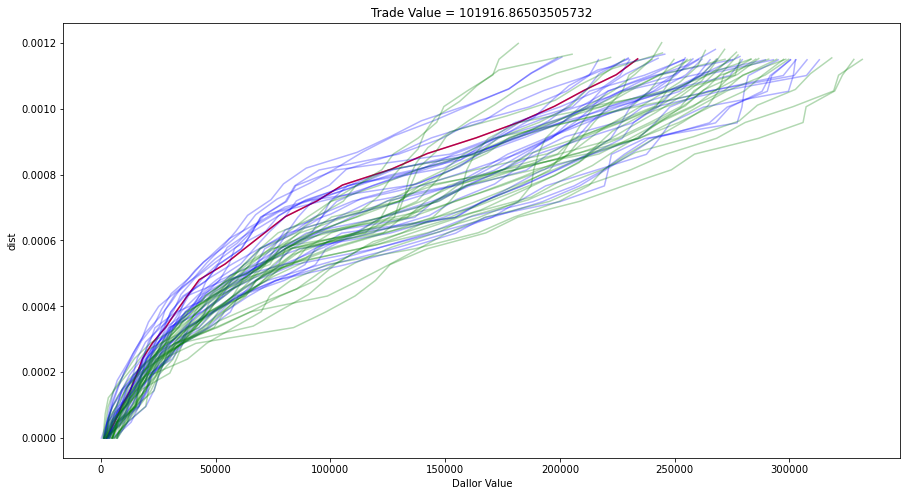

In [162]:
os.chdir(r'C:\Users\杜威\Desktop\tardis\yurong')
from file_tools import save_variable,load_variable
bi1 = load_variable('dfs_no_shift_binance.txt')
coin = coin_ls[0]
dt = kk_own_trade(coin)
dt['time_D'] = (dt['time'] + timedelta(hours = -8)).dt.floor('D')
dt0 = dt[['time_D','sum']].groupby('time_D', as_index=False).sum()
for date in tqdm(dt['time_D'][:1]):
    plot_depth(date, dt, coin)

In [103]:
def split_df(side,df):
    f_gettime = lambda x: datetime.fromtimestamp((x) / 1000000)  ##get datatime_type
    df['time'] = df.timestamp.map(f_gettime)
    ls = ['time']
    for col in df.columns:
        if side in col:
            ls.append(col)
    df = df[ls]
    ls = ['time']
    amount = 0
    df['value_-1'] = 0
    df['amount_-1'] = 0
    for i in range(25):
        df[f'value_{i}'] = df[f'value_{i-1}'] + df[f'{side}s[{i}].price'] * df[f'{side}s[{i}].amount']
        df[f'amount_{i}'] = df[f'amount_{i-1}'] + df[f'{side}s[{i}].amount']
        df[f'dist_{i}'] = df[f'{side}s[{i}].price'] / df[f'{side}s[0].price'] - 1
        for name in ['value','amount','dist']:
            ls.append(f'{name}_{i}')
    df = df[ls]
    return df

In [108]:
ask = split_df('bid',df)

In [109]:
ask = ask.iloc[2000:,:]

In [110]:
ask['time'] = ask['time'].dt.floor('min')
def get_line(arr):
    return np.percentile(arr,30)
ask_line = ask.iloc[2000:,:].groupby('time',as_index = True).agg(get_line)

In [111]:
date = ask_line.index[1]
df1 = ask[ask['time'] == date]
df2 = ask_line[ask_line.index == date]

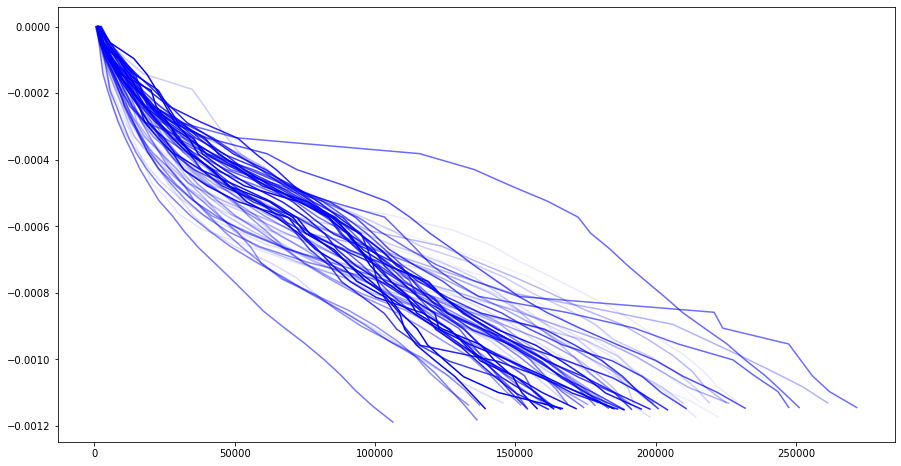

In [112]:
plt.figure(figsize=(15, 8))
for i in range(60):
    date = ask_line.index[i]
    df1 = ask[ask['time'] == date]
    df2 = ask_line[ask_line.index == date]
    value = df2.iloc[:,range(0,74,3)].values.reshape(-1)
    dist = df2.iloc[:,range(2,75,3)].values.reshape(-1)
    plt.plot(value,dist,color = 'blue',alpha = (1-i/60))

In [107]:
    coin = 'SOL'
    side = 'ask'
    x = 'value'
    plt.figure(figsize=(15, 8))
    for i in range(25):
        plt.scatter(df1[f'{x}_{i}'],df1[f'dist_{i}'],color = 'blue',alpha = 0.1)
    value = df2.iloc[:,range(0,74,3)].values.reshape(-1)
    dist = df2.iloc[:,range(2,75,3)].values.reshape(-1)
    plt.plot(value,dist,label = 'pred_depth',color = 'red')
    plt.title(f'{coin}_{side}_{date}')
    plt.xlabel(x.upper())
    plt.ylabel(f'dist')
    plt.legend()

NameError: name 'df1' is not defined

<Figure size 1080x576 with 0 Axes>

In [14]:
ex = 'live_1'
part = 'kraken_1'
coin = 'dot'
func = {
    'e':get_out_bi,
    'f':st_f,
    'e & f':st_f_e
}
bi1 = load_variable('dfs_no_shift_binance.txt')
for st in ['e','f','e & f'][:1]:
    bi = bi1[ex][coin.upper()]['best']
    bi['pos'] = bi['change'].cumsum()
    bi['index'] = bi.index
    bi2 = func[st](bi,balance_map[part][coin],0.2,0.2)

In [15]:
f_gettime = lambda x: datetime.fromtimestamp((x) / 1000000)  ##get datatime_type
bi2['time'] = bi2.ts.map(f_gettime).dt.floor('s')
bi2 = bi2[['time','change']].groupby('time',as_index = False).sum()

In [33]:
ask['time'] = ask['time'].dt.floor('s')
ask_line = ask[['time','value_7']].groupby('time',as_index = False).mean()

In [34]:
df_t = bi2['time']
df_t = pd.merge(df_t,ask_line,on='time',how = 'inner')

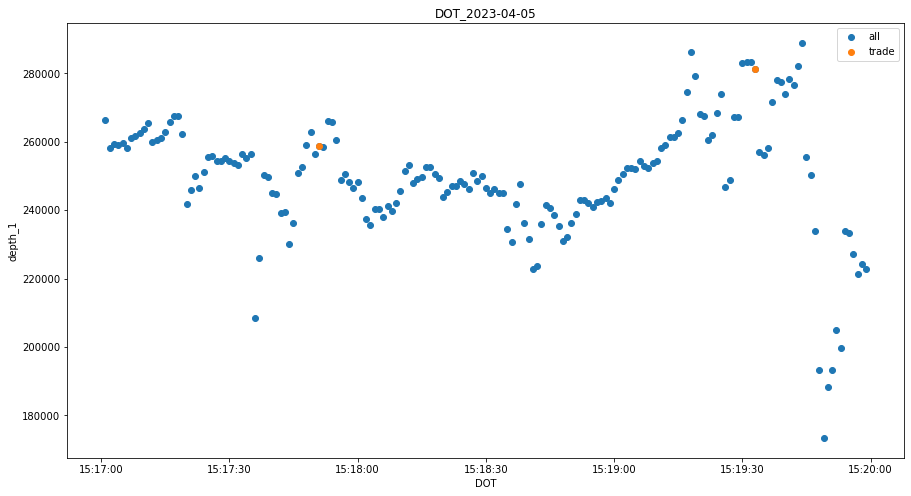

In [35]:
begin = '2023-04-05 15:17:00'
end = '2023-04-05 15:20:00'
df_t = df_t[(df_t['time'] > begin) & (df_t['time'] < end)]
ask_line = ask_line[(ask_line['time'] > begin) & (ask_line['time'] < end)]
plt.figure(figsize=(15, 8))
plt.scatter(ask_line.time,ask_line.value_7,label = 'all')
plt.scatter(df_t.time,df_t.value_7,label = 'trade')
plt.title(f'DOT_2023-04-05')
plt.xlabel('DOT'.upper())
plt.ylabel(f'depth_1')
plt.legend()

# binance strategy

In [6]:
os.chdir(r'C:\Users\杜威\Desktop\tardis\yurong')
from file_tools import save_variable,load_variable
bi1 = load_variable('dfs_no_shift_binance.txt')

In [3]:
def get_x(coin):
    df = []
    for file in os.listdir(f'C:/Users/杜威/Desktop/tardis/kk_trade_record'):
        if coin in file:
            dt = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/kk_trade_record/{file}')
            df.append(dt)
    df = pd.concat(df)
    df = df.sort_values(by = 'time')
    df = df.drop_duplicates(subset='ts')
    return df

In [4]:
def clean_x(df0, x):
    dfx = pd.merge(df0, x.iloc[:,3:], on = ['ts'], how = 'left')
    dfx.iloc[1,0] += dfx.iloc[0,0]
    dfx = dfx.iloc[1:,:]
    dfx['pos'] = dfx['change'].cumsum()
    dfx['pos_'] = dfx['pos'].shift(1).fillna(0)
    dfx = dfx[~dfx.isna().T.any()]
    dfx['change'] = dfx['pos'] - dfx['pos_']
    ls = ['pos', 'price', 'change', 'trend_5', 'trend_30', 'trend_300', 'vol_5', 'vol_30', 'vol_300', 'diff_5', 'diff_30', 'diff_300']
    dfx = dfx[ls]
    return dfx

In [5]:
for coin in bi1['live_1'].keys():
    xs = get_x(coin)
    df = []
    for part in bi1.keys():
        df0 = bi1[part][coin]['best']
        dfx = clean_x(df0, xs)
        df.append(dfx)
    df = pd.concat(df)
    df.describe(percentiles = np.arange(0,1.0,0.1)).to_csv(f'C:/Users/杜威/Desktop/tardis/profit/new x/desc/{coin}.csv')

In [5]:
def get_lim_dic(per):
    lim_dic = {}
    for x in df.columns[4:]:
        lim_dic[x] = {}
    for coin in bi1['live_1'].keys():
        df = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/profit/new x/desc/{coin}.csv')
        for x in df.columns[4:]:
            lim_dic[x][coin.lower()] =  df[x][14] 
    def load_text(name):
        f = open(f'C:/Users/杜威/Desktop/tardis/balance/{name}.txt','r')
        a = f.read()
        tt = eval(a)
        f.close()
        return tt
    balance_map = load_text('balance_map')
    lim_dic['pos'] = balance_map
    return lim_dic

In [13]:
lim_dic = {}
for x in ['trend_5', 'vol_5', 'diff_5','trend_30', 'vol_30', 'diff_300','trend_300', 'vol_300', 'diff_300']:
    lim_dic[x] = {}
for coin in bi1['live_1'].keys():
    df = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/profit/new x/desc/{coin}.csv')
    for x in ['trend_5', 'vol_5', 'diff_5','trend_30', 'vol_30', 'diff_300','trend_300', 'vol_300', 'diff_300']:
        lim_dic[x][coin.lower()] =  df[x][14] * 0.2

In [14]:
def load_text(name):
    f = open(f'C:/Users/杜威/Desktop/tardis/balance/{name}.txt','r')
    a = f.read()
    tt = eval(a)
    f.close()
    return tt
balance_map = load_text('balance_map')
lim_dic['pos'] = balance_map

In [17]:
def F1(bi,lm,percent,factor):
    high = lm * percent
    low = -1 * high
    note = lambda x: 1  if abs(x) > high else 0
    bi['note'] = bi[factor].map(note)
    bi = bi[(bi['note'] == 1) ]
    return bi

def cal_ret(coin,lm,ex,per,factor, xs):
    df0 = bi1[ex][coin]['best']
    dfx = clean_x(df0, xs)
    bi = F1(dfx,lm,per,factor)
    df = bi[:]
    df['change'] = df['pos'] - df['pos'].shift(1).fillna(0)
    ret_fp = (df['change'] * (-1)).cumsum().iloc[-1] * df['price'][df.index[-1]] + (df['change'] * df['price']).cumsum().iloc[-1]
    fee = np.sum(abs(df['change']) * df['price'] * 0.000155)
    return ret_fp,fee

def cal_mult_ret(coin, ex, factor_ls, per, xs):
    df0 = bi1[ex][coin]['best']
    bi = clean_x(df0, xs)
    for factor in factor_ls:
        part = 'kraken_1'
        if ex[-1] != '1':
            part = 'kraken_2'
        if factor == 'pos':
            lim = lim_dic[factor][part]
        else:
            lim = lim_dic[factor]
        bi = F1(bi,lim[coin.lower()],per,factor)
    df = bi[:]
    df['change'] = df['pos'] - df['pos'].shift(1).fillna(0)
    ret_fp = (df['change'] * (-1)).cumsum().iloc[-1] * df['price'][df.index[-1]] + (df['change'] * df['price']).cumsum().iloc[-1]
    fee = np.sum(abs(df['change']) * df['price'] * 0.000155)
    return ret_fp,fee

def plot_x(coin, xs):
    pos_ls = np.arange(0,0.51,0.01)
    plt.figure(figsize=(15, 8))
    for factor in ['trend_30', 'vol_30', 'diff_30', 'pos']:
        nete_ls = []
        for per in pos_ls:
            nete = 0
            for ex in bi1.keys():
                part = 'kraken_1'
                if ex[-1] != '1':
                    part = 'kraken_2'
                if factor == 'pos':
                    lim = lim_dic[factor][part]
                else:
                    lim = lim_dic[factor]
                ret_fp,fee = cal_ret(coin,lim[coin.lower()],ex,per,factor, xs)
                nete = ret_fp - fee + nete
            nete_ls.append(nete)
        plt.plot(pos_ls,nete_ls,label = f'{factor}')
    plt.plot(pos_ls,[nete_ls[0] for i in nete_ls],label = 'A')
    plt.title(f'{coin}_net_ret')
    plt.xlabel('Hedging threshold')
    plt.ylabel('Dallor value')
    plt.legend()
    plt.savefig(f'C:/Users/杜威/Desktop/tardis/profit/new x/plot/30_100/{coin}.jpg')
    
def plot_mult_x(coin, xs):
    factor_ls = ['trend_5', 'pos']
    L = ''
    for f in factor_ls:
        L = L + ' + ' + f
    pos_ls = np.arange(0,0.51,0.01)
    plt.figure(figsize=(15, 8))
    nete_ls = []
    for per in pos_ls:
        nete = 0
        for ex in bi1.keys():
            ret_fp,fee = cal_mult_ret(coin, ex, factor_ls, per, xs)
            nete = ret_fp - fee + nete
        nete_ls.append(nete)
    plt.plot(pos_ls,nete_ls,label = f'{L}')
    plt.plot(pos_ls,[nete_ls[0] for i in nete_ls],label = 'A')
    plt.title(f'{coin}_net_ret')
    plt.xlabel('Hedging threshold')
    plt.ylabel('Dallor value')
    plt.legend()
    plt.savefig(f'C:/Users/杜威/Desktop/tardis/profit/new x/plot/mult_5/{coin}.jpg')

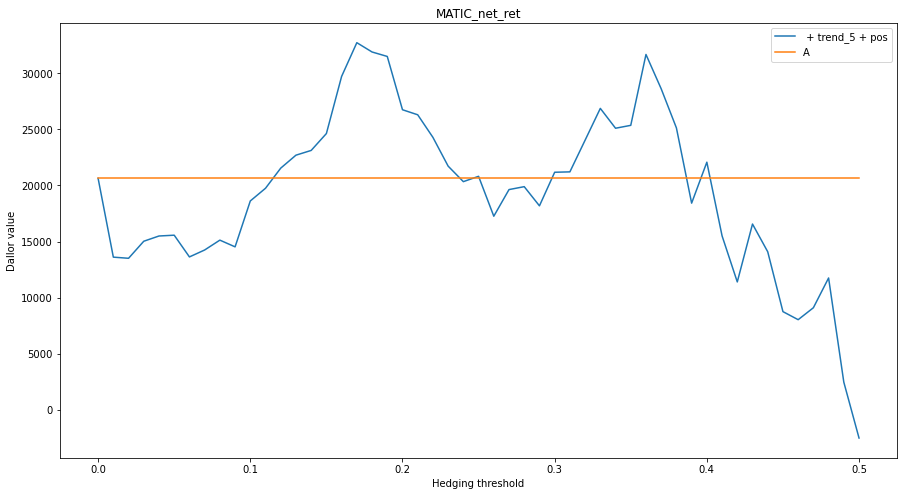

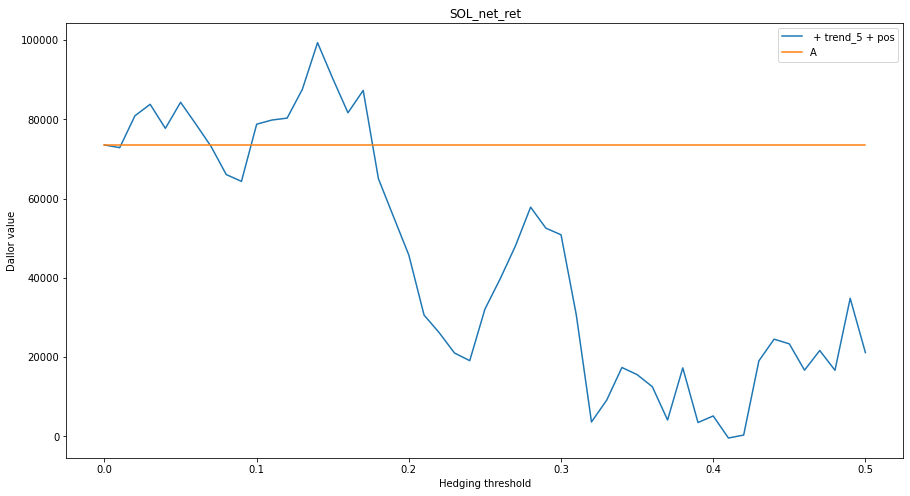

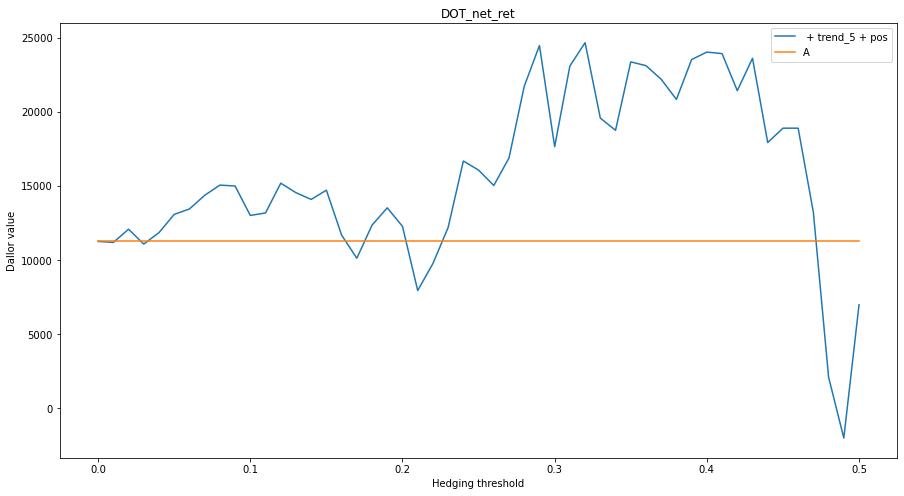

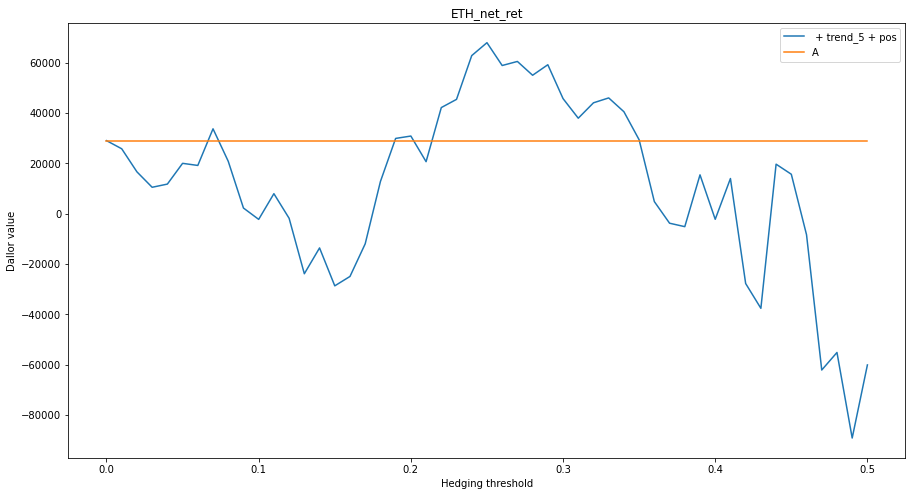

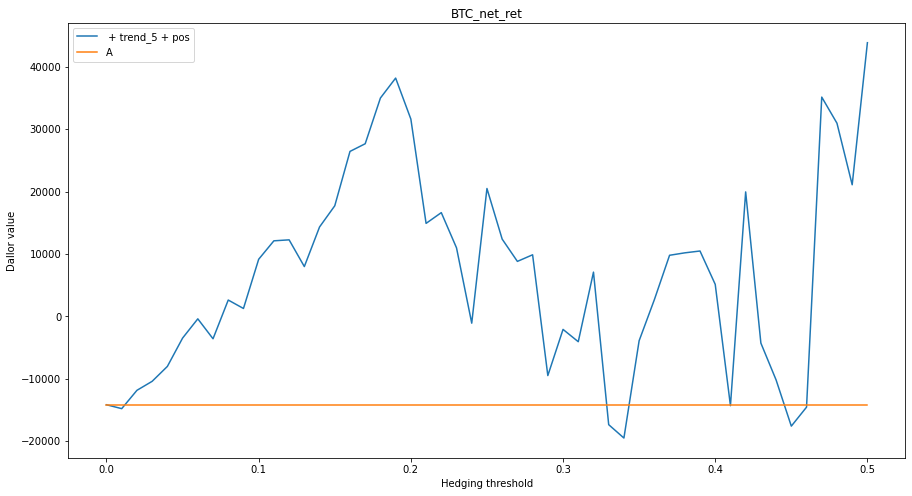

In [18]:
for coin in ['matic','sol','dot','eth','btc']:
    coin = coin.upper()
    xs = get_x(coin)
    #plot_x(coin, xs)
    plot_mult_x(coin, xs)

In [ ]:
def pos_choose(pos_bi_now, pos_kk_now, lim):
    hedge_pos = pos_kk_now * -1
    pos_bi_next = hedge_pos
    if abs(hedge_pos) < lim :
        pos_bi_next = pos_bi_now
    elif ( hedge_pos > 0 ) and ( hedge_pos < pos_bi_now ):
        pos_bi_next = pos_bi_now
    elif ( hedge_pos < 0 ) and ( hedge_pos > pos_bi_now ):
        pos_bi_next = pos_bi_now
    return pos_bi_next

In [8]:
def st_f(bi,balance_lm,percent):
    bi = bi[['pos','price','change']]
    lm = balance_lm * percent
    arr = bi.to_numpy()
    records = np.empty((len(arr), 3), dtype=object)
    pos = 0
    for i in range(len(arr)):
        pos_raw = arr[i][0]
        price = arr[i][1]
        gap = pos - pos_raw
        if gap > lm :
            pos = pos_raw + lm
        elif gap <= (lm * (-1)) :
            pos = pos_raw - lm
        record = np.array([pos,price,pos_raw])
        records[i] = record

    columns = ['pos','price','pos_raw']
    records_df = pd.DataFrame(records, columns=columns)
    records_df['index'] = records_df.index
    return records_df

def st_f_e(bi,balance_lm,percent,per2):
    bi = bi[['pos','price','change']]
    lm = balance_lm * percent
    pos_lm = balance_lm * per2
    arr = bi.to_numpy()
    records = np.empty((len(arr), 3), dtype=object)
    pos = 0
    for i in range(len(arr)):
        pos_raw = arr[i][0]
        price = arr[i][1]
        ch = arr[i][2]
        if (pos_raw - pos) * pos_raw >= 0:
            if abs(pos_raw) >= lm:
                pos = pos_raw
        gap = pos - pos_raw
        if gap > pos_lm :
            pos = pos_raw + pos_lm
        elif gap <= (pos_lm * (-1)) :
            pos = pos_raw - pos_lm
        record = np.array([pos,price,pos_raw])
        records[i] = record
    columns = ['pos','price','pos_raw']
    records_df = pd.DataFrame(records, columns=columns)
    records_df['index'] = records_df.index
    return records_df

def get_out_bi(bi,balance_lm,percent,per):
    high = balance_lm * percent
    low = -1 * high
    note = lambda x: 1  if x>high or x<low else 0
    bi['note'] = bi['pos'].map(note)
    bi = bi[(bi['note'] == 1) ]
    return bi

def get_out_bi2(bi,balance_lm,percent1,percent2):
    open_lm = balance_lm * percent1
    close_lm = balance_lm * percent2
    def note(x,change):
        if (x - change) * change < 0:
            if x > open_lm or x < (-1 * open_lm) :
                return 1
            else:
                return 0
        if (x - change) * change > 0:
            if x > close_lm or x < (-1 * close_lm) :
                return 1
            else:
                return 0
    bi['note'] = list(map(note,bi['pos'],bi['change']))
    bi = bi[bi['note'] == 1]
    return bi

def find_close(bi2,balance_lm,percent1):
    return get_out_bi2(bi2,balance_lm,0.2,percent1)
    prols = []
    for per2 in np.arange(0,0.91,0.01):
        bi = bi2[:]
        bi = get_out_bi2(bi,balance_lm,percent1,per2)
        balance = bi[:]
        balance_ = balance['pos'].values
        pos_change = np.diff(np.append(0,balance_))
        price = balance['price'].values
        arr_change = np.vstack([pos_change,price])
        df = pd.DataFrame(arr_change.T,columns=['change','price'])
        ret_fp = (df['change'] * (-1)).cumsum().iloc[-1] * price[-1] + (df['change'] * df['price']).cumsum().iloc[-1]
        fee = np.sum(abs(df['change']) * df['price'] * 0.000155)
        prols.append(ret_fp - fee)
    per2 = np.argmax(prols) * 0.01
    return get_out_bi2(bi2,balance_lm,percent1,per2)
        
def get_ret(coin,balance_lm,ex,func,per,per2):
    bi = bi1[ex][coin.upper()]['best']
    bi['pos'] = bi['change'].cumsum()
    bi = func(bi,balance_lm,per,per2)
    balance = bi[:]
    balance_ = balance['pos'].values
    pos_change = np.diff(np.append(0,balance_))
    price = balance['price'].values
    arr_change = np.vstack([pos_change,price])
    df = pd.DataFrame(arr_change.T,columns=['change','price'])
    ret_fp = (df['change'] * (-1)).cumsum().iloc[-1] * price[-1] + (df['change'] * df['price']).cumsum().iloc[-1]
    fee = np.sum(abs(df['change']) * df['price'] * 0.000155)
    return ret_fp,fee

def plot_coin_percent(coin):
    pos_ls = np.arange(0,0.91,0.01)
    nete_ls = []
    nete2_ls = []
    nete3_ls = []
    feels = []
    retls = []
    for per in pos_ls:
        nete = 0
        nete2 = 0
        nete3 = 0
        feea = 0
        reta = 0
        for ex in bi1.keys():
            part = 'kraken_1'
            if ex[-1] != '1':
                part = 'kraken_2'
            ret_fp,fee = get_ret(coin,balance_map[part][coin],ex,get_out_bi,per,per)
            nete = ret_fp - fee + nete
            feea = feea + fee
            reta = ret_fp + reta
            ret_fp,fee = get_ret(coin,balance_map[part][coin],ex,st_f_e,per,per)
            nete2 = ret_fp - fee + nete2
            ret_fp,fee = get_ret(coin,balance_map[part][coin],ex,st_f_e,per,0.2)
            nete3 = ret_fp - fee + nete3
        feels.append(feea)
        retls.append(reta)
        nete_ls.append(nete)
        nete2_ls.append(nete2)
        nete3_ls.append(nete3)
    #df = grid(coin)
    #df = pd.DataFrame(df)
    #df['max'] = df.max(axis = 1)
    plt.figure(figsize=(15, 8))
    #plt.plot(pos_ls,nete_ls,label = 'strategy_e')
    plt.plot(pos_ls,nete2_ls,label = 'e&f float')
    plt.plot(pos_ls,nete3_ls,label = 'e&f fixed0.2')
    #plt.plot(pos_ls,feels,label = 'fee')
    #plt.plot(pos_ls,retls,label = 'raw_profit')
    #plt.plot(pos_ls,df['max'],label = 'strategy_e^2')
    plt.plot(pos_ls,[nete_ls[0] for i in nete_ls],label = 'strategy_a')
    plt.title(f'{coin}_pos_ret')
    plt.xlabel('Hedging threshold')
    plt.ylabel('Dallor value')
    plt.legend()
    plt.savefig(f'C:/Users/杜威/Desktop/tardis/profit/pos_ret/{coin}.jpg')  

    
def plot_percent(coin,balance_lm,ex):
    pos_ls = np.arange(0,1.01,0.01)
    ret_ls = []
    fee_ls = []
    net_ls = []
    for per in pos_ls:
        ret_fp,fee = get_ret(coin,balance_lm,ex)
        ret_ls.append(ret_fp)
        fee_ls.append(fee)
        net_ls.append(ret_fp-fee)
    plt.figure(figsize=(15, 8))
    plt.plot(pos_ls,ret_ls,label = 'ret')
    plt.plot(pos_ls,fee_ls,label = 'fee')
    plt.plot(pos_ls,net_ls,label = 'net_ret')
    plt.plot(pos_ls,[net_ls[0] for i in net_ls],label = 'strategy_a')
    plt.title(f'{coin}_pos_ret')
    plt.xlabel('Hedging threshold')
    plt.ylabel('Dallor value')
    plt.legend()
    plt.savefig(f'C:/Users/杜威/Desktop/tardis/profit/F/{coin}/{ex}.jpg')  
    

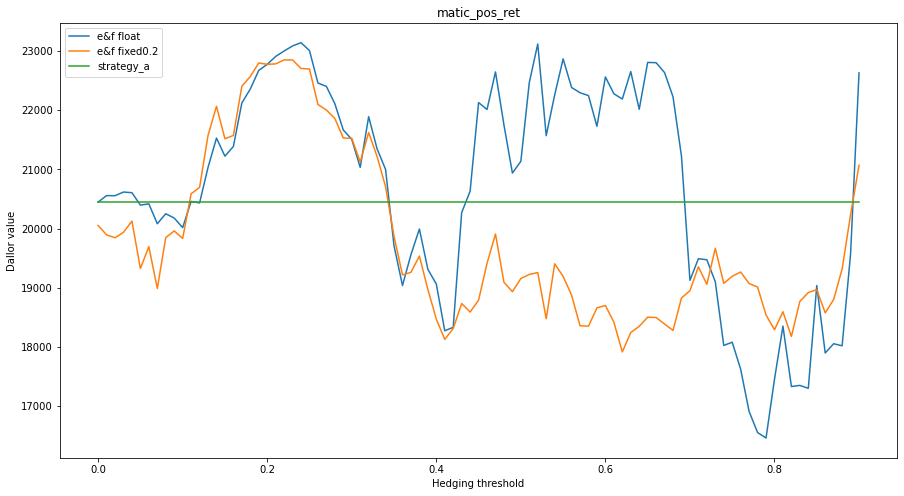

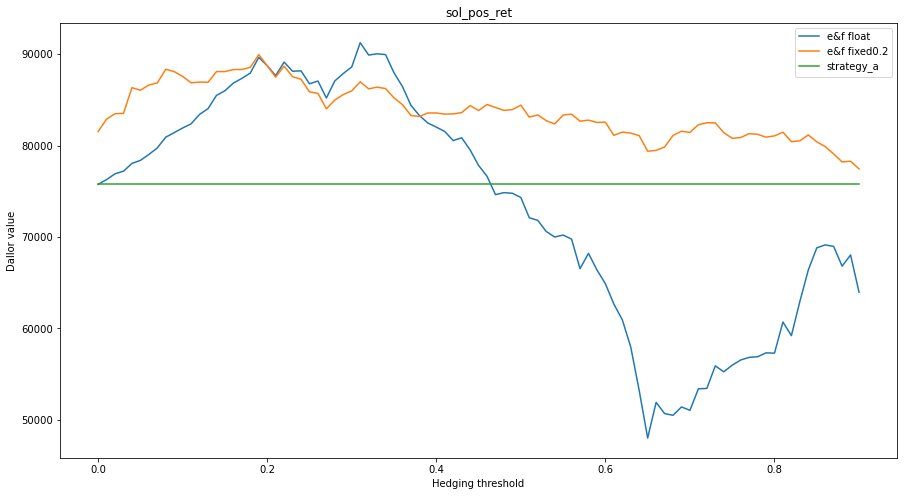

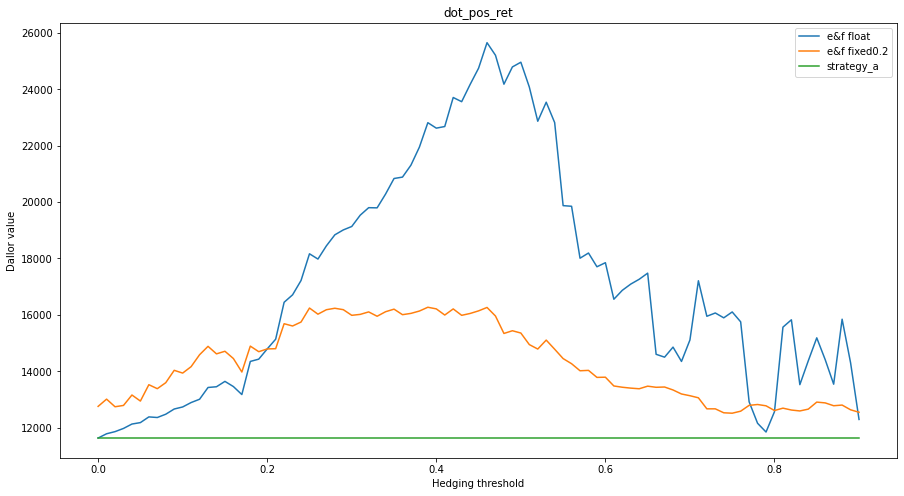

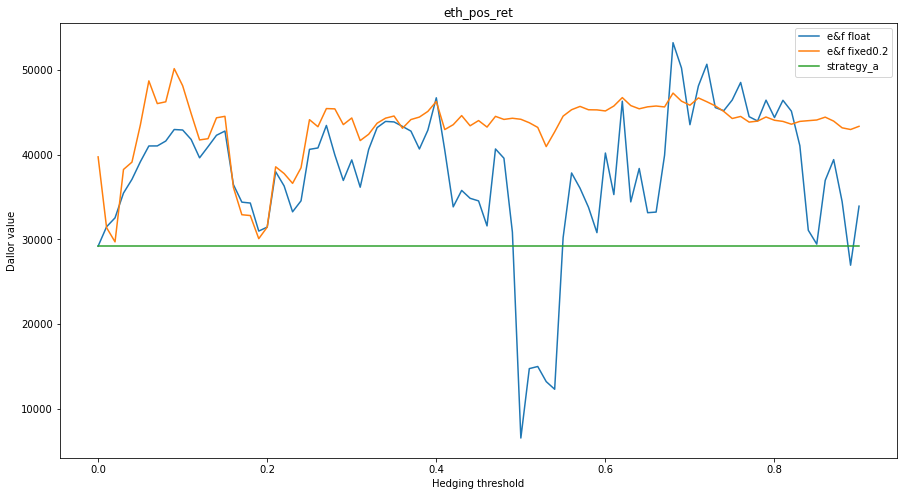

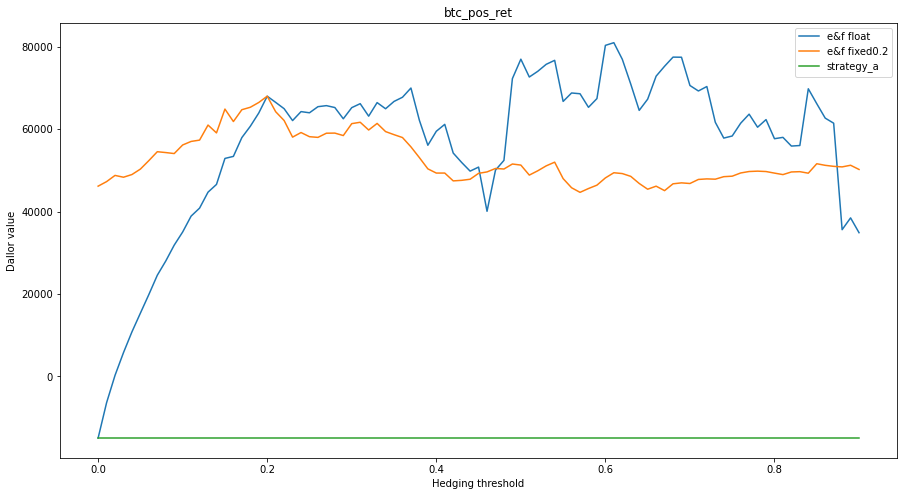

In [59]:
bi1 = load_variable('dfs_no_shift_binance.txt')
for coin in ['matic','sol','dot','eth','btc']:
    plot_coin_percent(coin)

In [21]:
def grid(coin):
    prols = []
    for per1 in np.arange(0,0.91,0.01):
        prol = []
        for per2 in np.arange(0,0.91,0.01):
            pro = 0
            for ex in bi1.keys():
                part = 'kraken_1'
                if ex[-1] != '1':
                    part = 'kraken_2'
                bi = bi1[ex][coin.upper()]['best']
                bi['pos'] = bi['change'].cumsum()
                bi['index'] = bi.index
                bi = get_out_bi2(bi,balance_map[part][coin],per1,per2)
                balance = bi[:]
                balance_ = balance['pos'].values
                pos_change = np.diff(np.append(0,balance_))
                price = balance['price'].values
                arr_change = np.vstack([pos_change,price])
                df = pd.DataFrame(arr_change.T,columns=['change','price'])
                ret_fp = (df['change'] * (-1)).cumsum().iloc[-1] * price[-1] + (df['change'] * df['price']).cumsum().iloc[-1]
                fee = np.sum(abs(df['change']) * df['price'] * 0.000155)
                pro += ret_fp - fee
            prol.append(pro)
        prols.append(prol)
    return prols

In [12]:
ex = 'live_1'
part = 'kraken_1'
coin = 'btc'
bi1 = load_variable('dfs_no_shift_binance.txt')
for per in [0.3]:
    bi = bi1[ex][coin.upper()]['best']
    bi['pos'] = bi['change'].cumsum()
    bi['index'] = bi.index

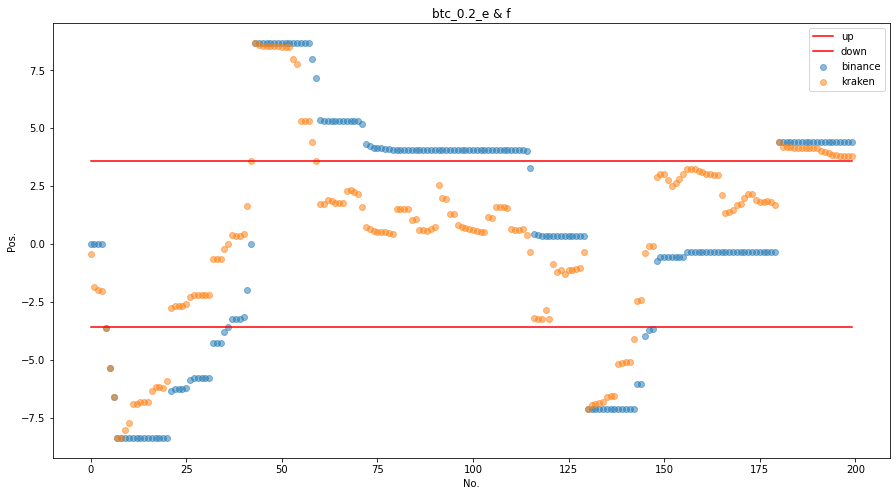

In [7]:
ex = 'live_1'
part = 'kraken_1'
coin = 'btc'
bi1 = load_variable('dfs_no_shift_binance.txt')
func = {
    'e':get_out_bi,
    'f':st_f,
    'e & f':st_f_e
}
per = 0.2
Len = 200
for st in ['e','f','e & f'][-1:]:
    bi = bi1[ex][coin.upper()]['best']
    bi['pos'] = bi['change'].cumsum()
    bi['index'] = bi.index
    bi = func[st](bi,balance_map[part][coin],per,per)
    #bi_ = bi_[['index','pos']]
    #bi.rename(columns = {'pos':'pos_raw'},inplace = True)
    #bi = pd.merge(bi,bi_,on=['index'],how = 'left').ffill().fillna(0)
    bi = bi.iloc[:Len,:]
    plt.figure(figsize=(15, 8))
    plt.scatter(bi.index,bi.pos,label = 'binance',alpha = 0.5)
    try:
        plt.scatter(bi.index,bi['pos_raw'].mean(axis = 1),label = 'kraken',alpha = 0.5)
    except:
        plt.scatter(bi.index,bi['pos_raw'],label = 'kraken',alpha = 0.5)
    plt.plot(bi.index,[per * balance_map[part][coin]] * Len,label = 'up',color = 'r')
    plt.plot(bi.index,[-1 * per * balance_map[part][coin]] * Len,label = 'down',color = 'r')
    plt.title(f'{coin}_{per}_{st}')
    plt.xlabel('No.')
    plt.ylabel('Pos.')
    plt.legend()
    plt.savefig(f'C:/Users/杜威/Desktop/tardis/profit/pos_ret/pos_mt/{coin}_{per}_{st}.jpg')